# Manchester City — pass network & average positions
This notebook demonstrates how to load a StatsBomb match, extract passes, compute average player positions, and plot a basic pass network using `mplsoccer` and `networkx`.

In [1]:
import pandas as pd
import numpy as np
from statsbombpy import sb
import networkx as nx
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import os, time
pd.set_option('display.max_columns', 200)

In [2]:
comps = sb.competitions()
# show candidates containing 'Premier' and '2015' so we can pick 2015_16
cands = comps[comps.competition_name.str.contains('Premier', case=False, na=False) & comps.season_name.str.contains('2015', case=False, na=False)]
display(cands[['competition_id','competition_name','season_id','season_name','country_name']].drop_duplicates())
# If the table shows the Premier League 2015_16 row, note the competition_id and season_id (we'll programmatically select it below).

competition_id competition_name  season_id season_name country_name
64               2   Premier League         27   2015/2016      England

In [3]:
# choose the row found above (this should match the table you just displayed)
row = cands.iloc[0]
competition_id = int(row.competition_id)
season_id = int(row.season_id)
print("Using competition_id:", competition_id, "season_id:", season_id, "->", row.competition_name, row.season_name)

Using competition_id: 2 season_id: 27 -> Premier League 2015/2016


In [7]:
# Robust replacement for Cell 4 — handles 'match_date' and missing 'venue'
import pandas as pd

# Ensure `matches` exists; if not, re-fetch for the chosen competition/season as fallback
try:
    matches
except NameError:
    try:
        matches = sb.matches(competition_id=competition_id, season_id=season_id)
    except Exception:
        matches = sb.matches()

# 1) show available columns so we can see the real names
print("Matches columns available:\n", list(matches.columns))

# 2) pick a date-like column (prefer 'match_date')
preferred_dates = ['match_date','date','utc_date','kick_off','kickoff','date_utc']
date_col = None
for c in preferred_dates:
    if c in matches.columns:
        date_col = c
        break
# fallback: any column containing 'date'
if date_col is None:
    for c in matches.columns:
        if 'date' in c.lower():
            date_col = c
            break

print("Using date column:", date_col)

# 3) build a safe list of team columns (use whichever exist)
team_candidates = ['home_team','away_team','home','away','home_name','away_name',
                   'home_team_name','away_team_name','team_home','team_away']
cols_to_show = []
if 'match_id' in matches.columns:
    cols_to_show.append('match_id')
for c in team_candidates:
    if c in matches.columns and c not in cols_to_show:
        cols_to_show.append(c)
# include date column if found
if date_col and date_col not in cols_to_show:
    cols_to_show.append(date_col)

# if cols_to_show empty, show first 6 columns (safe fallback)
if not cols_to_show:
    cols_to_show = list(matches.columns[:6])

print("\nShowing sample matches (first 40 rows) using available columns:")
display(matches[cols_to_show].head(40))

# 4) flexible Manchester City filter: try several plausible column names
def contains_team(series, team_name='Manchester City'):
    # handle NaNs and different formats
    return series.astype(str).str.contains(team_name, case=False, na=False)

home_col = None
away_col = None
for c in matches.columns:
    if any(k in c.lower() for k in ['home', 'home_team']) and home_col is None:
        home_col = c
    if any(k in c.lower() for k in ['away', 'away_team']) and away_col is None:
        away_col = c

# build boolean mask (handle missing cols)
mask = pd.Series(False, index=matches.index)
if home_col is not None:
    mask = mask | contains_team(matches[home_col], 'Manchester City')
if away_col is not None:
    mask = mask | contains_team(matches[away_col], 'Manchester City')

mc_matches = matches[mask].drop_duplicates().reset_index(drop=True)

# sort by date column if available
if date_col:
    try:
        mc_matches = mc_matches.sort_values(by=date_col).reset_index(drop=True)
    except Exception:
        pass

print("\nManchester City matches found (showing same available columns):")
display(mc_matches[cols_to_show].head(40))
print("\nTotal Man City matches found:", len(mc_matches))

# 5) default match_id selection
if len(mc_matches) > 0 and 'match_id' in mc_matches.columns:
    match_id = int(mc_matches.iloc[0].match_id)
    print(f"\nDefaulting to first match_id = {match_id}. If you want a different match, set match_id = <id> manually and re-run the event-loading cell.")
else:
    match_id = None
    print("\nNo match_id auto-selected. Pick a match_id from the table above and set `match_id` manually.")

Matches columns available:
 ['match_id', 'match_date', 'kick_off', 'competition', 'season', 'home_team', 'away_team', 'home_score', 'away_score', 'match_status', 'match_status_360', 'last_updated', 'last_updated_360', 'match_week', 'competition_stage', 'stadium', 'referee', 'home_managers', 'away_managers', 'data_version', 'shot_fidelity_version', 'xy_fidelity_version']
Using date column: match_date

Showing sample matches (first 40 rows) using available columns:


match_id             home_team             away_team  match_date
0    3754058        Leicester City       AFC Bournemouth  2016-01-02
1    3754245  West Bromwich Albion            Sunderland  2015-10-17
2    3754136      Newcastle United           Aston Villa  2015-12-19
3    3754037               Everton       AFC Bournemouth  2016-04-30
4    3754039        Crystal Palace               Watford  2016-02-13
5    3754041               Arsenal           Aston Villa  2016-05-15
6    3754042  West Bromwich Albion             Liverpool  2016-05-15
7    3754043     Tottenham Hotspur       AFC Bournemouth  2016-03-20
8    3754045        Leicester City       Manchester City  2015-12-29
9    3754048        Crystal Palace               Everton  2016-04-13
10   3754049        Leicester City          Norwich City  2016-02-27
11   3754050            Sunderland        Crystal Palace  2016-03-01
12   3754052  West Bromwich Albion          Norwich City  2016-03-19
13   3754053           Aston Villa     Tottenham Hotspur  2016-03-13
14   3754055             Liverpool               Chelsea  2016-05-11
15   3754226            Sunderland             Liverpool  2015-12-30
16   3754014            Stoke City     Manchester United  2015-12-26
17   3754091            Stoke City               Watford  2015-10-24
18   3754135            Stoke City       Manchester City  2015-12-05
19   3754293            Stoke City               Chelsea  2015-11-07
20   3754339            Stoke City       AFC Bournemouth  2015-09-26
21   3754146            Stoke City        Leicester City  2015-09-19
22   3754347     Manchester United       West Ham United  2015-12-05
23   3754255             Liverpool  West Bromwich Albion  2015-12-13
24   3754278       AFC Bournemouth               Watford  2015-10-03
25   3753979        Crystal Palace            Sunderland  2015-11-23
26   3753972          Swansea City       AFC Bournemouth  2015-11-21
27   3753978           Southampton          Swansea City  2015-09-26
28   3753974      Newcastle United               Everton  2015-12-26
29   3753993            Sunderland          Norwich City  2015-08-15
30   3753983          Swansea City               Arsenal  2015-10-31
31   3754015     Manchester United       Manchester City  2015-10-25
32   3754038          Norwich City               Arsenal  2015-11-29
33   3754001      Newcastle United               Chelsea  2015-09-26
34   3754007            Stoke City  West Bromwich Albion  2015-08-29
35   3754008     Manchester United            Sunderland  2015-09-26
36   3754029     Tottenham Hotspur           Aston Villa  2015-11-02
37   3753995               Chelsea           Southampton  2015-10-03
38   3753999               Watford               Arsenal  2015-10-17
39   3754017           Aston Villa          Swansea City  2015-10-24


Manchester City matches found (showing same available columns):


match_id             home_team             away_team  match_date
0    3754145  West Bromwich Albion       Manchester City  2015-08-10
1    3754066       Manchester City               Chelsea  2015-08-16
2    3754233               Everton       Manchester City  2015-08-23
3    3754246       Manchester City               Watford  2015-08-29
4    3754257        Crystal Palace       Manchester City  2015-09-12
5    3754077       Manchester City       West Ham United  2015-09-19
6    3754197     Tottenham Hotspur       Manchester City  2015-09-26
7    3754079       Manchester City      Newcastle United  2015-10-03
8    3754193       Manchester City       AFC Bournemouth  2015-10-17
9    3754015     Manchester United       Manchester City  2015-10-25
10   3754167       Manchester City          Norwich City  2015-10-31
11   3754258           Aston Villa       Manchester City  2015-11-08
12   3754208       Manchester City             Liverpool  2015-11-21
13   3754028       Manchester City           Southampton  2015-11-28
14   3754135            Stoke City       Manchester City  2015-12-05
15   3754328       Manchester City          Swansea City  2015-12-12
16   3754296               Arsenal       Manchester City  2015-12-21
17   3754054       Manchester City            Sunderland  2015-12-26
18   3754045        Leicester City       Manchester City  2015-12-29
19   3754346               Watford       Manchester City  2016-01-02
20   3754142       Manchester City               Everton  2016-01-13
21   3754260       Manchester City        Crystal Palace  2016-01-16
22   3754110       West Ham United       Manchester City  2016-01-23
23   3754095            Sunderland       Manchester City  2016-02-02
24   3754290       Manchester City        Leicester City  2016-02-06
25   3754147       Manchester City     Tottenham Hotspur  2016-02-14
26   3753991             Liverpool       Manchester City  2016-03-02
27   3754249       Manchester City           Aston Villa  2016-03-05
28   3754313          Norwich City       Manchester City  2016-03-12
29   3754124       Manchester City     Manchester United  2016-03-20
30   3754144       AFC Bournemouth       Manchester City  2016-04-02
31   3754035       Manchester City  West Bromwich Albion  2016-04-09
32   3754322               Chelsea       Manchester City  2016-04-16
33   3754206      Newcastle United       Manchester City  2016-04-19
34   3754307       Manchester City            Stoke City  2016-04-23
35   3754320           Southampton       Manchester City  2016-05-01
36   3754314       Manchester City               Arsenal  2016-05-08
37   3754149          Swansea City       Manchester City  2016-05-15


Total Man City matches found: 38

Defaulting to first match_id = 3754145. If you want a different match, set match_id = <id> manually and re-run the event-loading cell.


In [8]:
import pandas as pd, numpy as np
import time, os
from statsbombpy import sb
import networkx as nx
import matplotlib.pyplot as plt
from mplsoccer import Pitch

pd.set_option('display.max_columns', 200)

In [9]:
# mc_matches should already be defined from the previous cell that showed 38 matches.
# show match ids and index
display(mc_matches[['match_id','match_date']].reset_index().rename(columns={'index':'idx'}).head(40))
match_ids = mc_matches['match_id'].astype(int).tolist()
print("Found", len(match_ids), "match_ids. Sample:", match_ids[:5])

idx  match_id  match_date
0     0   3754145  2015-08-10
1     1   3754066  2015-08-16
2     2   3754233  2015-08-23
3     3   3754246  2015-08-29
4     4   3754257  2015-09-12
5     5   3754077  2015-09-19
6     6   3754197  2015-09-26
7     7   3754079  2015-10-03
8     8   3754193  2015-10-17
9     9   3754015  2015-10-25
10   10   3754167  2015-10-31
11   11   3754258  2015-11-08
12   12   3754208  2015-11-21
13   13   3754028  2015-11-28
14   14   3754135  2015-12-05
15   15   3754328  2015-12-12
16   16   3754296  2015-12-21
17   17   3754054  2015-12-26
18   18   3754045  2015-12-29
19   19   3754346  2016-01-02
20   20   3754142  2016-01-13
21   21   3754260  2016-01-16
22   22   3754110  2016-01-23
23   23   3754095  2016-02-02
24   24   3754290  2016-02-06
25   25   3754147  2016-02-14
26   26   3753991  2016-03-02
27   27   3754249  2016-03-05
28   28   3754313  2016-03-12
29   29   3754124  2016-03-20
30   30   3754144  2016-04-02
31   31   3754035  2016-04-09
32   32   3754322  2016-04-16
33   33   3754206  2016-04-19
34   34   3754307  2016-04-23
35   35   3754320  2016-05-01
36   36   3754314  2016-05-08
37   37   3754149  2016-05-15

Found 38 match_ids. Sample: [3754145, 3754066, 3754233, 3754246, 3754257]


In [10]:
# We'll collect all passes into a list then concat. This may take 1-2 minutes.
all_passes = []
failed = []

def safe_start(ev):
    loc = ev.get('location')
    return (loc[0], loc[1]) if isinstance(loc, list) and len(loc)>=2 else (np.nan,np.nan)

def safe_end(ev):
    p = ev.get('pass') or {}
    end = p.get('end_location')
    return (end[0], end[1]) if isinstance(end, list) and len(end)>=2 else (np.nan,np.nan)

def safe_recipient(ev):
    p = ev.get('pass') or {}
    rec = p.get('recipient')
    if isinstance(rec, dict):
        return rec.get('name')
    return rec

def safe_completed(ev):
    p = ev.get('pass') or {}
    return ('outcome' not in p) or (p.get('outcome') is None)

for idx, mid in enumerate(match_ids, start=1):
    try:
        print(f"[{idx}/{len(match_ids)}] Loading match_id={mid} ...", end=' ')
        events = sb.events(match_id=int(mid))
        passes = events[events['type']=='Pass'].copy()
        if passes.empty:
            print("no passes")
            continue
        # extract coords
        starts = passes.apply(lambda r: pd.Series(safe_start(r)), axis=1, result_type='expand')
        starts.columns = ['start_x','start_y']
        ends = passes.apply(lambda r: pd.Series(safe_end(r)), axis=1, result_type='expand')
        ends.columns = ['end_x','end_y']
        passes[['start_x','start_y','end_x','end_y']] = pd.concat([starts, ends], axis=1)
        passes['recipient_name'] = passes.apply(safe_recipient, axis=1)
        passes['completed'] = passes.apply(safe_completed, axis=1)
        passes['match_id'] = int(mid)
        # keep only columns we care about to save memory
        keep_cols = [c for c in ['match_id','period','minute','second','team','player','start_x','start_y','end_x','end_y','recipient_name','completed'] if c in passes.columns]
        passes = passes[keep_cols].copy()
        all_passes.append(passes)
        print("ok, passes:", len(passes))
        time.sleep(0.15)
    except Exception as e:
        print("ERROR:", e)
        failed.append((mid,str(e)))

print("\nLoaded matches:", len(all_passes), "Failed:", len(failed))
if failed:
    print("Failures examples:", failed[:5])
# concat
passes_df = pd.concat(all_passes, ignore_index=True)
print("Total passes rows collected:", len(passes_df))

[1/38] Loading match_id=3754145 ... ok, passes: 1183
[2/38] Loading match_id=3754066 ... ok, passes: 933
[3/38] Loading match_id=3754233 ... ok, passes: 1004
[4/38] Loading match_id=3754246 ... ok, passes: 1184
[5/38] Loading match_id=3754257 ... ok, passes: 977
[6/38] Loading match_id=3754077 ... ok, passes: 1064
[7/38] Loading match_id=3754197 ... ok, passes: 999
[8/38] Loading match_id=3754079 ... ok, passes: 986
[9/38] Loading match_id=3754193 ... ok, passes: 1116
[10/38] Loading match_id=3754015 ... ok, passes: 1028
[11/38] Loading match_id=3754167 ... ok, passes: 1123
[12/38] Loading match_id=3754258 ... ok, passes: 1072
[13/38] Loading match_id=3754208 ... ok, passes: 1027
[14/38] Loading match_id=3754028 ... ok, passes: 949
[15/38] Loading match_id=3754135 ... ok, passes: 976
[16/38] Loading match_id=3754328 ... ok, passes: 1131
[17/38] Loading match_id=3754296 ... ok, passes: 1132
[18/38] Loading match_id=3754054 ... ok, passes: 993
[19/38] Loading match_id=3754045 ... ok, pas

In [11]:
# Prefer explicit 'team' column if present
if 'team' in passes_df.columns:
    mc_passes = passes_df[passes_df['team'].astype(str).str.contains('Manchester City', case=False, na=False)].copy()
else:
    # fallback: find players who appear most in mc_matches lineups? Simpler fallback: keep passes where player name is seen > threshold
    # Build player frequency and keep top players as likely MC players
    player_counts = passes_df['player'].value_counts().head(40)
    probable_players = [p for p in player_counts.index if 'de' in p.lower() or 'aguero' in p.lower() or 'sterling' in p.lower()][:30]  # quick heuristic
    mc_passes = passes_df[passes_df['player'].isin(probable_players)].copy()
    print("Fallback team filtering used; probable players:", probable_players)

print("Manchester City passes (rows):", len(mc_passes))
display(mc_passes.head())

Manchester City passes (rows): 22340


match_id  period  minute  second             team  \
0   3754145       1       0       0  Manchester City   
1   3754145       1       0       1  Manchester City   
2   3754145       1       0       3  Manchester City   
3   3754145       1       0       6  Manchester City   
4   3754145       1       0       8  Manchester City   

                      player  start_x  start_y  end_x  end_y recipient_name  \
0     Wilfried Guemiand Bony     61.0     40.1    NaN    NaN           None   
1  David Josué Jiménez Silva     59.5     39.0    NaN    NaN           None   
2        Gnégnéri Yaya Touré     52.7     44.4    NaN    NaN           None   
3               Bacary Sagna     41.1     69.7    NaN    NaN           None   
4         Fernando Luiz Rosa     44.4     42.2    NaN    NaN           None   

   completed  
0       True  
1       True  
2       True  
3       True  
4       True

In [12]:
# How many passes lack end coords?
num_end_na = passes_df['end_x'].isna().sum()
total = len(passes_df)
print(f"end_x NaNs: {num_end_na} / {total} ({100*num_end_na/total:.1f}%)")

# How many are marked completed vs not?
print("completed counts:")
print(passes_df['completed'].value_counts(dropna=False))

# Among completed passes, how many have end coords missing?
comp = passes_df[passes_df['completed']==True]
print("completed passes missing end coords:", comp['end_x'].isna().sum(), "of", len(comp))

# show some completed passes that lack end coords to inspect their raw structure
display(comp[comp['end_x'].isna()].head(10))

end_x NaNs: 39186 / 39186 (100.0%)
completed counts:
completed
True    39186
Name: count, dtype: int64
completed passes missing end coords: 39186 of 39186


match_id  period  minute  second             team  \
0   3754145       1       0       0  Manchester City   
1   3754145       1       0       1  Manchester City   
2   3754145       1       0       3  Manchester City   
3   3754145       1       0       6  Manchester City   
4   3754145       1       0       8  Manchester City   
5   3754145       1       0      11  Manchester City   
6   3754145       1       0      13  Manchester City   
7   3754145       1       0      15  Manchester City   
8   3754145       1       0      18  Manchester City   
9   3754145       1       0      22  Manchester City   

                      player  start_x  start_y  end_x  end_y recipient_name  \
0     Wilfried Guemiand Bony     61.0     40.1    NaN    NaN           None   
1  David Josué Jiménez Silva     59.5     39.0    NaN    NaN           None   
2        Gnégnéri Yaya Touré     52.7     44.4    NaN    NaN           None   
3               Bacary Sagna     41.1     69.7    NaN    NaN           None   
4         Fernando Luiz Rosa     44.4     42.2    NaN    NaN           None   
5           Eliaquim Mangala     43.0     13.4    NaN    NaN           None   
6         Aleksandar Kolarov     47.3      5.8    NaN    NaN           None   
7           Eliaquim Mangala     35.5     25.0    NaN    NaN           None   
8            Vincent Kompany     31.7     56.9    NaN    NaN           None   
9               Bacary Sagna     49.6     75.1    NaN    NaN           None   

   completed  
0       True  
1       True  
2       True  
3       True  
4       True  
5       True  
6       True  
7       True  
8       True  
9       True

In [13]:
# run this to inspect the DataFrame schema
print("passes_df shape:", passes_df.shape)
cols = list(passes_df.columns)
print("columns:", cols)
# show any columns containing 'end' or 'pass' to spot flattened fields
print("\nColumns containing 'end':", [c for c in cols if 'end' in c.lower()])
print("Columns containing 'pass':", [c for c in cols if 'pass' in c.lower()])

passes_df shape: (39186, 12)
columns: ['match_id', 'period', 'minute', 'second', 'team', 'player', 'start_x', 'start_y', 'end_x', 'end_y', 'recipient_name', 'completed']

Columns containing 'end': ['end_x', 'end_y']
Columns containing 'pass': []


In [16]:
import pprint, math

# choose a row that exists
row_idx = 7
row = passes_df.iloc[row_idx]
mid = int(row['match_id'])
print("Inspecting match_id", mid, "row index", row_idx, "player:", row.get('player'))

# fetch raw events for that match and find the first Pass event
events = sb.events(match_id=mid)
pprint.pprint(type(events))
# find first pass event object and print its 'pass' sub-dict and keys
found = False
for i, ev in events.iterrows():
    if ev['type'] == 'Pass':
        print("\n-- Found a Pass event in raw events --\n")
        pprint.pprint({k: ev.get(k) for k in ['id','type','minute','second','team','player','location','pass']})
        # also show the 'pass' dict specifically
        p_dict = ev.get('pass') or {}
        print("\npass keys:", list(p_dict.keys()))
        pprint.pprint(p_dict)
        found = True
        break

if not found:
    print("No Pass event found in this match's events (unexpected).")

Inspecting match_id 3754145 row index 7 player: Eliaquim Mangala
<class 'pandas.core.frame.DataFrame'>

-- Found a Pass event in raw events --

{'id': 'e804b380-ae42-4e80-9c18-d970184a8a20',
 'location': [61.0, 40.1],
 'minute': 0,
 'pass': None,
 'player': 'Wilfried Guemiand Bony',
 'second': 0,
 'team': 'Manchester City',
 'type': 'Pass'}

pass keys: []
{}


In [17]:
import numpy as np

def find_end_from_row(r):
    # 1) nested dict under 'pass'
    p = r.get('pass') or {}
    if isinstance(p, dict):
        end = p.get('end_location') or p.get('endLocation') or p.get('end_loc')
        if isinstance(end, (list, tuple)) and len(end) >= 2:
            return float(end[0]), float(end[1])
    # 2) flattened column names that sometimes appear like 'pass_end_location' (tuple/list) or separate columns
    for candidate in ['pass_end_location', 'pass_end_loc', 'pass_end', 'pass_end_x','pass_end_y','pass_endlocation']:
        if candidate in r.index:
            val = r.get(candidate)
            if isinstance(val, (list, tuple)) and len(val)>=2:
                return float(val[0]), float(val[1])
    # if there are separate columns pass_end_x / pass_end_y
    for xname,yname in [('pass_end_x','pass_end_y'), ('end_x','end_y'), ('pass_endlocation_x','pass_endlocation_y')]:
        if xname in r.index and yname in r.index:
            xv, yv = r.get(xname), r.get(yname)
            if not (pd.isna(xv) or pd.isna(yv)):
                try:
                    return float(xv), float(yv)
                except Exception:
                    pass
    # 3) some datasets include 'carry' with end_location for carries which are not passes (unlikely here)
    carry = r.get('carry') or {}
    if isinstance(carry, dict):
        end = carry.get('end_location')
        if isinstance(end, (list, tuple)) and len(end)>=2:
            return float(end[0]), float(end[1])
    # 4) last resort: look for any column whose name contains 'end' and is a list-like
    for c in r.index:
        if 'end' in c.lower():
            val = r.get(c)
            if isinstance(val, (list, tuple)) and len(val)>=2:
                return float(val[0]), float(val[1])
    # nothing found
    return np.nan, np.nan

# apply to a small sample to test speed & correctness
test = passes_df.head(50).apply(lambda r: pd.Series(find_end_from_row(r)), axis=1)
test.columns = ['end_x2','end_y2']
display(test.head(10))

end_x2  end_y2
0     NaN     NaN
1     NaN     NaN
2     NaN     NaN
3     NaN     NaN
4     NaN     NaN
5     NaN     NaN
6     NaN     NaN
7     NaN     NaN
8     NaN     NaN
9     NaN     NaN

In [18]:
# compute end_x2/end_y2 for all rows (this may take a moment)
new_coords = passes_df.apply(lambda r: pd.Series(find_end_from_row(r)), axis=1)
new_coords.columns = ['end_x2','end_y2']
passes_df = pd.concat([passes_df, new_coords], axis=1)

# report how many non-null end coords we recovered
num_recovered = passes_df['end_x2'].notna().sum()
total = len(passes_df)
print(f"Recovered end coords: {num_recovered} / {total} ({100*num_recovered/total:.1f}%)")

# show examples where original end_x was NaN but we recovered a coordinate
mask = passes_df['end_x'].isna() & passes_df['end_x2'].notna()
display(passes_df[mask].head(10)[['match_id','player','start_x','start_y','end_x','end_x2','end_y','end_y2','recipient_name','completed']])

Recovered end coords: 0 / 39186 (0.0%)


Empty DataFrame
Columns: [match_id, player, start_x, start_y, end_x, end_x2, end_y, end_y2, recipient_name, completed]
Index: []

In [19]:
# Heuristic rebuild: infer pass recipients & end coords from event sequence per match
import pandas as pd
import numpy as np
from statsbombpy import sb
import time

reconstructed = []   # will hold per-pass dicts

def get_loc(ev):
    # return (x,y) if event has 'location' list, else (nan,nan)
    loc = ev.get('location')
    if isinstance(loc, (list, tuple)) and len(loc) >= 2:
        return float(loc[0]), float(loc[1])
    return np.nan, np.nan

for idx, mid in enumerate(match_ids, start=1):
    print(f"[{idx}/{len(match_ids)}] processing match {mid} ...", end=' ')
    events = sb.events(match_id=int(mid)).reset_index(drop=True)  # ensure integer index 0..N-1
    n = len(events)
    for i in range(n):
        ev = events.iloc[i].to_dict()
        if ev.get('type') != 'Pass':
            continue
        sender = ev.get('player')
        team = ev.get('team')  # may be string or dict; coerce
        if isinstance(team, dict):
            team_name = team.get('name')
        else:
            team_name = team
        sx, sy = get_loc(ev)  # start coords from this pass event
        # try prefer pass nested info if present
        p = ev.get('pass') or {}
        rx = ry = None
        recipient = None
        if isinstance(p, dict) and p.get('end_location'):
            end = p.get('end_location')
            if isinstance(end, (list, tuple)) and len(end) >= 2:
                rx, ry = float(end[0]), float(end[1])
            # check recipient field
            rec = p.get('recipient')
            if isinstance(rec, dict):
                recipient = rec.get('name')
            elif isinstance(rec, str):
                recipient = rec
        # if no end found from nested pass, look to next event(s)
        if rx is None or np.isnan(rx):
            # look ahead up to 3 events to handle small interleaving events
            for j in range(i+1, min(i+4, n)):
                ev2 = events.iloc[j].to_dict()
                # if event has a team field, extract name
                t2 = ev2.get('team')
                t2_name = t2.get('name') if isinstance(t2, dict) else t2
                # if same team, assign recipient = next player and end coords = next event location
                if t2_name and team_name and str(t2_name).strip().lower() == str(team_name).strip().lower():
                    # don't treat the same player passing twice in a row as recipient
                    p2_player = ev2.get('player')
                    if p2_player and p2_player != sender:
                        recipient = p2_player
                        rx, ry = get_loc(ev2)
                        break
                    # if it's same player (self pass?), still use location
                    recipient = p2_player
                    rx, ry = get_loc(ev2)
                    break
                # if next event is by other team, pass likely unsuccessful/intercepted — stop
                if t2_name and team_name and str(t2_name).strip().lower() != str(team_name).strip().lower():
                    # leave recipient None (incomplete/turnover)
                    break
            # end lookahead
        completed_flag = True
        # if nested pass has 'outcome' and it's not None -> incomplete
        if isinstance(p, dict) and 'outcome' in p and p.get('outcome') is not None:
            completed_flag = False
        reconstructed.append({
            'match_id': int(mid),
            'player': sender,
            'team': team_name,
            'start_x': sx, 'start_y': sy,
            'end_x': (float(rx) if (rx is not None and not pd.isna(rx)) else np.nan),
            'end_y': (float(ry) if (ry is not None and not pd.isna(ry)) else np.nan),
            'recipient_name': recipient,
            'completed': bool(completed_flag),
            'minute': ev.get('minute'),
            'second': ev.get('second')
        })
    time.sleep(0.12)

mc_passes2 = pd.DataFrame(reconstructed)
print("Reconstructed passes rows:", len(mc_passes2))
print("End coords non-null:", mc_passes2['end_x'].notna().sum(), "/", len(mc_passes2))
print("Recipient non-null:", mc_passes2['recipient_name'].notna().sum(), "/", len(mc_passes2))

# Keep only Manchester City rows (robust substring)
mc_passes2 = mc_passes2[mc_passes2['team'].astype(str).str.contains('manchester city', case=False, na=False)].reset_index(drop=True)
print("Manchester City passes after filtering:", len(mc_passes2))
display(mc_passes2.head())

[1/38] processing match 3754145 ... [2/38] processing match 3754066 ... [3/38] processing match 3754233 ... [4/38] processing match 3754246 ... [5/38] processing match 3754257 ... [6/38] processing match 3754077 ... [7/38] processing match 3754197 ... [8/38] processing match 3754079 ... [9/38] processing match 3754193 ... [10/38] processing match 3754015 ... [11/38] processing match 3754167 ... [12/38] processing match 3754258 ... [13/38] processing match 3754208 ... [14/38] processing match 3754028 ... [15/38] processing match 3754135 ... [16/38] processing match 3754328 ... [17/38] processing match 3754296 ... [18/38] processing match 3754054 ... [19/38] processing match 3754045 ... [20/38] processing match 3754346 ... [21/38] processing match 3754142 ... [22/38] processing match 3754260 ... [23/38] processing match 3754110 ... [24/38] processing match 3754095 ... [25/38] processing match 3754290 ... [26/38] processing match 3754147 ... [27/38] processing match 3753991 ... [28/38] pr

match_id                     player             team  start_x  start_y  \
0   3754145     Wilfried Guemiand Bony  Manchester City     61.0     40.1   
1   3754145  David Josué Jiménez Silva  Manchester City     59.5     39.0   
2   3754145        Gnégnéri Yaya Touré  Manchester City     52.7     44.4   
3   3754145               Bacary Sagna  Manchester City     41.1     69.7   
4   3754145         Fernando Luiz Rosa  Manchester City     44.4     42.2   

   end_x  end_y             recipient_name  completed  minute  second  
0   59.5   39.0  David Josué Jiménez Silva       True       0       0  
1   52.7   44.4        Gnégnéri Yaya Touré       True       0       1  
2   41.1   69.7               Bacary Sagna       True       0       3  
3   44.4   42.2         Fernando Luiz Rosa       True       0       6  
4   43.0   13.4           Eliaquim Mangala       True       0       8

In [20]:
# restrict to completed passes with recipient
completed = mc_passes2[mc_passes2['completed'] & mc_passes2['recipient_name'].notna()].copy()

# player avg positions (start + receive mean)
starts = mc_passes2.groupby('player')[['start_x','start_y']].mean().rename(columns={'start_x':'sx','start_y':'sy'})
receives = mc_passes2.groupby('recipient_name')[['end_x','end_y']].mean().rename(columns={'end_x':'rx','end_y':'ry'})
avgpos = pd.concat([starts, receives], axis=1)
avgpos['x'] = avgpos[['sx','rx']].mean(axis=1)
avgpos['y'] = avgpos[['sy','ry']].mean(axis=1)
avgpos = avgpos[['x','y']].dropna()

# edges counts
edges = completed.groupby(['player','recipient_name']).size().reset_index(name='count')
edges = edges[edges['player'] != edges['recipient_name']]
edges = edges.sort_values('count', ascending=False)
display(edges.head(30))

player             recipient_name  count
31                  Bacary Sagna       Jesús Navas González    370
205         Jesús Navas González               Bacary Sagna    316
146           Fernando Luiz Rosa        Gnégnéri Yaya Touré    217
189          Gnégnéri Yaya Touré         Fernando Luiz Rosa    209
34                  Bacary Sagna            Kevin De Bruyne    199
72              Eliaquim Mangala         Aleksandar Kolarov    198
140           Fernando Luiz Rosa  David Josué Jiménez Silva    173
16            Aleksandar Kolarov            Raheem Sterling    171
184          Gnégnéri Yaya Touré               Bacary Sagna    169
322      Nicolás Hernán Otamendi               Bacary Sagna    162
137           Fernando Luiz Rosa         Aleksandar Kolarov    155
185          Gnégnéri Yaya Touré  David Josué Jiménez Silva    154
28                  Bacary Sagna         Fernando Luiz Rosa    150
59     David Josué Jiménez Silva        Gnégnéri Yaya Touré    150
271              Kevin De Bruyne               Bacary Sagna    148
86              Eliaquim Mangala    Nicolás Hernán Otamendi    147
138           Fernando Luiz Rosa               Bacary Sagna    146
30                  Bacary Sagna        Gnégnéri Yaya Touré    143
37                  Bacary Sagna    Nicolás Hernán Otamendi    141
354  Pablo Javier Zabaleta Girod       Jesús Navas González    139
371              Raheem Sterling         Aleksandar Kolarov    129
6             Aleksandar Kolarov         Fernando Luiz Rosa    128
324      Nicolás Hernán Otamendi           Eliaquim Mangala    127
57     David Josué Jiménez Silva         Fernando Luiz Rosa    127
41                  Bacary Sagna            Vincent Kompany    127
183          Gnégnéri Yaya Touré         Aleksandar Kolarov    126
3             Aleksandar Kolarov           Eliaquim Mangala    126
150           Fernando Luiz Rosa            Kevin De Bruyne    124
2             Aleksandar Kolarov  David Josué Jiménez Silva    123
327      Nicolás Hernán Otamendi         Fernando Luiz Rosa    120

In [21]:
# PARAMETERS — tweak these to taste
NUM_PLAYERS = 11            # number of nodes (players) to show
MIN_PASS_ATTEMPTS = 3       # prune edges with fewer attempts
CORNER_RADIUS = 12.0        # distance (units) from corner to treat as a corner-origin (tweak)
LONG_PASS_LENGTH = 40.0     # passes longer than this (units) considered long (tweak)
PITCH_LENGTH = 120.0        # StatsBomb pitch x-range
PITCH_WIDTH = 80.0          # StatsBomb pitch y-range

# helpers
import numpy as np, pandas as pd, math
from math import hypot

def distance(a,b):
    if pd.isna(a) or pd.isna(b): return np.nan
    return float(hypot(a[0]-b[0], a[1]-b[1]))

def point_in_corner(x,y,corner_radius=CORNER_RADIUS):
    # four corners: (0,0), (0,PITCH_WIDTH), (PITCH_LENGTH,0), (PITCH_LENGTH,PITCH_WIDTH)
    # return True if within radius of any corner
    corners = [(0.0,0.0), (0.0,PITCH_WIDTH), (PITCH_LENGTH,0.0), (PITCH_LENGTH,PITCH_WIDTH)]
    for cx,cy in corners:
        if hypot(x-cx, y-cy) <= corner_radius:
            return True
    return False

def pass_length(row):
    if pd.isna(row.get('start_x')) or pd.isna(row.get('end_x')):
        return np.nan
    return hypot(row['end_x']-row['start_x'], row['end_y']-row['start_y'])

In [22]:
# assume mc_passes2 exists from your reconstruction step
df = mc_passes2.copy()   # work on a copy

# compute inferred pass length where possible
df['pass_length'] = df.apply(lambda r: pass_length(r), axis=1)

# flag corners (start in corner box) using heuristic
df['is_corner'] = df.apply(lambda r: point_in_corner(r['start_x'], r['start_y']) if (not pd.isna(r['start_x']) and not pd.isna(r['start_y'])) else False, axis=1)

# flag long passes (simple length threshold)
df['is_long_pass'] = df['pass_length'].apply(lambda L: True if (not pd.isna(L) and L >= LONG_PASS_LENGTH) else False)

# show counts to confirm heuristics
print("Total passes:", len(df))
print("Passes with inferred end coords:", df['end_x'].notna().sum())
print("Corner-origin passes:", df['is_corner'].sum())
print("Long passes (>= {:.0f}):".format(LONG_PASS_LENGTH), df['is_long_pass'].sum())

# quick view
display(df[['match_id','player','team','start_x','start_y','end_x','end_y','recipient_name','completed','pass_length','is_corner','is_long_pass']].head(10))

Total passes: 22340
Passes with inferred end coords: 18397
Corner-origin passes: 603
Long passes (>= 40): 1631


match_id                     player             team  start_x  start_y  \
0   3754145     Wilfried Guemiand Bony  Manchester City     61.0     40.1   
1   3754145  David Josué Jiménez Silva  Manchester City     59.5     39.0   
2   3754145        Gnégnéri Yaya Touré  Manchester City     52.7     44.4   
3   3754145               Bacary Sagna  Manchester City     41.1     69.7   
4   3754145         Fernando Luiz Rosa  Manchester City     44.4     42.2   
5   3754145           Eliaquim Mangala  Manchester City     43.0     13.4   
6   3754145         Aleksandar Kolarov  Manchester City     47.3      5.8   
7   3754145           Eliaquim Mangala  Manchester City     35.5     25.0   
8   3754145            Vincent Kompany  Manchester City     31.7     56.9   
9   3754145               Bacary Sagna  Manchester City     49.6     75.1   

   end_x  end_y             recipient_name  completed  pass_length  is_corner  \
0   59.5   39.0  David Josué Jiménez Silva       True     1.860108      False   
1   52.7   44.4        Gnégnéri Yaya Touré       True     8.683317      False   
2   41.1   69.7               Bacary Sagna       True    27.832535      False   
3   44.4   42.2         Fernando Luiz Rosa       True    27.697292      False   
4   43.0   13.4           Eliaquim Mangala       True    28.834008      False   
5   47.3    5.8         Aleksandar Kolarov       True     8.732125      False   
6   35.5   25.0           Eliaquim Mangala       True    22.536193      False   
7   31.7   56.9            Vincent Kompany       True    32.125535      False   
8   49.6   75.1               Bacary Sagna       True    25.527436      False   
9   74.4   70.6     Wilfried Guemiand Bony       True    25.204960      False   

   is_long_pass  
0         False  
1         False  
2         False  
3         False  
4         False  
5         False  
6         False  
7         False  
8         False  
9         False

In [23]:
EXCLUDE_LONG_PASSES = True   # set to False if you only want to exclude corners

# base filter: completed passes only and recipient known
base = df[(df['completed']==True) & (df['recipient_name'].notna())].copy()
print("Completed passes with recipient:", len(base))

if EXCLUDE_LONG_PASSES:
    filtered = base[ (~base['is_corner']) & (~base['is_long_pass']) ].copy()
    print("After excluding corners and long passes:", len(filtered))
else:
    filtered = base[ (~base['is_corner']) ].copy()
    print("After excluding corners only:", len(filtered))

# sanity: top players by touches (receiving or playing) after filtering
touches = pd.concat([filtered['player'], filtered['recipient_name']]).value_counts().rename_axis('player').reset_index(name='touches')
display(touches.head(20))

Completed passes with recipient: 18397
After excluding corners and long passes: 16468


player  touches
0                 Gnégnéri Yaya Touré     3069
1                  Fernando Luiz Rosa     3030
2                        Bacary Sagna     2878
3                  Aleksandar Kolarov     2396
4           David Josué Jiménez Silva     2332
5             Nicolás Hernán Otamendi     2317
6                Jesús Navas González     2130
7                     Kevin De Bruyne     1871
8                    Eliaquim Mangala     1549
9            Fernando Francisco Reges     1446
10                    Raheem Sterling     1395
11                        Gaël Clichy     1171
12  Sergio Leonel Agüero del Castillo     1130
13        Pablo Javier Zabaleta Girod     1097
14                    Vincent Kompany      987
15           Martín Gastón Demichelis      848
16                       Fabian Delph      764
17                        Samir Nasri      738
18             Wilfried Guemiand Bony      601
19                           Joe Hart      538

In [24]:
# compute touches (appearances as passer or recipient) in filtered data
touch_counts = pd.concat([filtered['player'], filtered['recipient_name']]).value_counts()
top_players = touch_counts.head(NUM_PLAYERS).index.tolist()
print("Top players chosen ({}):".format(NUM_PLAYERS), top_players)

# restrict dataset to passes where both sender and recipient are in top_players
mask_both_top = filtered['player'].isin(top_players) & filtered['recipient_name'].isin(top_players)
edges_df = filtered[mask_both_top].copy()
print("Edges rows among top players:", len(edges_df))

# compute avg positions for top players
starts = edges_df.groupby('player')[['start_x','start_y']].mean().rename(columns={'start_x':'sx','start_y':'sy'})
receives = edges_df.groupby('recipient_name')[['end_x','end_y']].mean().rename(columns={'end_x':'rx','end_y':'ry'})
avgpos = pd.concat([starts, receives], axis=1)
avgpos['x'] = avgpos[['sx','rx']].mean(axis=1)
avgpos['y'] = avgpos[['sy','ry']].mean(axis=1)
avgpos = avgpos[['x','y']].dropna().loc[top_players]   # ensure ordering by top_players
display(avgpos)

# compute touches per top player for node sizing
touch_df = touch_counts.reindex(top_players).rename_axis('player').reset_index(name='touches')
display(touch_df)

Top players chosen (11): ['Gnégnéri Yaya Touré', 'Fernando Luiz Rosa', 'Bacary Sagna', 'Aleksandar Kolarov', 'David Josué Jiménez Silva', 'Nicolás Hernán Otamendi', 'Jesús Navas González', 'Kevin De Bruyne', 'Eliaquim Mangala', 'Fernando Francisco Reges', 'Raheem Sterling']
Edges rows among top players: 9049


x          y
Gnégnéri Yaya Touré        67.600092  41.215267
Fernando Luiz Rosa         64.900506  39.728177
Bacary Sagna               70.663496  68.999256
Aleksandar Kolarov         70.327474   8.015113
David Josué Jiménez Silva  75.941902  37.159805
Nicolás Hernán Otamendi    50.490275  45.996264
Jesús Navas González       84.827980  66.916094
Kevin De Bruyne            81.471481  44.246806
Eliaquim Mangala           46.887958  26.006894
Fernando Francisco Reges   64.536324  41.935884
Raheem Sterling            82.745347  23.132898

player  touches
0         Gnégnéri Yaya Touré     3069
1          Fernando Luiz Rosa     3030
2                Bacary Sagna     2878
3          Aleksandar Kolarov     2396
4   David Josué Jiménez Silva     2332
5     Nicolás Hernán Otamendi     2317
6        Jesús Navas González     2130
7             Kevin De Bruyne     1871
8            Eliaquim Mangala     1549
9    Fernando Francisco Reges     1446
10            Raheem Sterling     1395

In [25]:
# -------------------------
# Build a position-aware starting XI: 1 GK, 4 DEF, 3 MID, 3 FWD
# -------------------------

import collections
import pandas as pd
from itertools import chain

# PARAMETERS for required counts
REQ = {'GK':1, 'DEF':4, 'MID':3, 'FWD':3}

# helper: map verbose position strings to broad groups
def map_pos_to_group(pos):
    if not isinstance(pos, str):
        return None
    s = pos.lower()
    if 'keeper' in s or 'goal' in s:    # goalkeeper / keeper
        return 'GK'
    if 'defend' in s or 'back' in s or 'centre back' in s or 'left back' in s or 'right back' in s:
        return 'DEF'
    if 'mid' in s or 'wing-back' in s or 'attacking midfield' in s or 'holding' in s:
        return 'MID'
    # treat 'forward', 'striker', 'attacker', 'wing' as FWD
    if 'forward' in s or 'striker' in s or 'attack' in s or 'wing' in s:
        return 'FWD'
    return None

# container for counts: player -> Counter of groups
appearance_counts = collections.defaultdict(collections.Counter)

# iterate matches and read lineups
for mid in match_ids:
    try:
        # sb.lineups may return a DataFrame or a list/dict; handle common possibilities
        lineup_obj = sb.lineups(match_id=int(mid))
    except Exception as e:
        # skip if lineups not available for that match
        # print(f"lineups error for {mid}: {e}")   # uncomment to debug
        continue

    # normalize to list of dataframes (one per team)
    lineups_list = []
    if isinstance(lineup_obj, pd.DataFrame):
        lineups_list = [lineup_obj]
    elif isinstance(lineup_obj, list):
        lineups_list = lineup_obj
    else:
        # sometimes sb.lineups returns a dict or other wrapper — try to coerce
        try:
            if hasattr(lineup_obj, 'data'): # some wrappers
                lineups_list = [pd.DataFrame(lineup_obj.data)]
            else:
                # last resort: convert to DataFrame
                lineups_list = [pd.DataFrame(lineup_obj)]
        except Exception:
            continue

    for lf in lineups_list:
        if lf is None or len(lf)==0:
            continue
        # standardise column names (lowercase)
        cols = {c.lower(): c for c in lf.columns}
        # find player name column
        player_col = None
        for cand in ['player','player_name','playerId','playerId_name','name']:
            if cand in cols:
                player_col = cols[cand]
                break
        # find position column
        pos_col = None
        for cand in ['position','player_position','role','pos','position_name']:
            if cand in cols:
                pos_col = cols[cand]
                break
        # find starter indicator (many dataframes have 'starter' or 'is_starting' or 'start')
        start_col = None
        for cand in ['starter','starting','is_starting','start','is_start','lineup']:
            if cand in cols:
                start_col = cols[cand]
                break

        # If we cannot find a player column, skip this df
        if player_col is None:
            continue

        # iterate rows and count only starters (if we can detect starter)
        for _, row in lf.iterrows():
            player = row.get(player_col)
            # detect starter: if start_col exists and truthy, otherwise assume lineup df lists only starters (common)
            is_starter = True
            if start_col is not None:
                val = row.get(start_col)
                if val is None:
                    is_starter = True
                else:
                    # consider truthy values (True, 'Starter', 1, 'Yes')
                    if isinstance(val, str):
                        is_starter = val.strip().lower() in ('true','starter','yes','y','1','start')
                    else:
                        is_starter = bool(val)
            # if not starter skip
            if not is_starter:
                continue

            # get pos mapping
            pos_raw = row.get(pos_col) if pos_col is not None else None
            broad = map_pos_to_group(pos_raw) if pos_raw is not None else None
            # fallback: sometimes pos info sits in a nested 'position' dict or 'role'
            if broad is None:
                # try other fields in row that include 'position' or 'role'
                for k in row.index:
                    if 'position' in str(k).lower() or 'role' in str(k).lower():
                        val = row.get(k)
                        broad = map_pos_to_group(val) if isinstance(val, str) else broad
                        if broad:
                            break
            # final fallback: skip counting if unknown
            if broad is None:
                continue
            # record one appearance
            appearance_counts[player][broad] += 1

# Summarise counts into per-group lists
group_to_players = {g: collections.Counter() for g in REQ.keys()}
for player, counter in appearance_counts.items():
    for grp, cnt in counter.items():
        if grp in group_to_players:
            group_to_players[grp][player] = cnt

# convert to ordered lists by appearances
for g in group_to_players:
    group_to_players[g] = [p for p, c in group_to_players[g].most_common()]

print("Players by group from lineups (top 10 each):")
for g in ['GK','DEF','MID','FWD']:
    print(g, group_to_players[g][:10])

# Now pick starting XI: prefer these lineup-based picks, else fallback to touches
# `touch_counts` expected from earlier; if not present compute it from filtered dataset:
try:
    touch_counts
except NameError:
    touch_counts = pd.concat([filtered['player'], filtered['recipient_name']]).value_counts()

# helper to fill players from group list, then fallback to top touch players excluding already chosen
chosen = []
chosen_set = set()

def pick_from_group(grp, needed):
    picks = []
    # from lineups first
    for p in group_to_players.get(grp, []):
        if p not in chosen_set and p in touch_counts.index:
            picks.append(p)
            chosen_set.add(p)
            chosen.append(p)
            if len(picks) >= needed:
                return picks
    # fallback: highest touch players whose broad group is unknown but likely (use heuristics)
    # take from touch_counts in order, skip already chosen
    for p in touch_counts.index:
        if p in chosen_set:
            continue
        # we can try to infer group by mapping avgpos y/x orientation if available (skip here)
        # For simplicity, just pick top touches to fill gaps
        picks.append(p)
        chosen_set.add(p)
        chosen.append(p)
        if len(picks) >= needed:
            break
    return picks

final_xi = []
for grp in ['GK','DEF','MID','FWD']:
    needed = REQ[grp]
    picks = pick_from_group(grp, needed)
    # if pick_from_group didn't fill due to no touch_counts, make sure we have needed length
    if len(picks) < needed:
        # pad with generic top touch players
        for p in touch_counts.index:
            if p not in chosen_set:
                picks.append(p)
                chosen_set.add(p)
                chosen.append(p)
            if len(picks) >= needed:
                break
    final_xi.extend(picks[:needed])

print("\nFinal starting XI (by group order GK, DEF, MID, FWD):")
print(final_xi)
starting_xi = final_xi  # ordered list

# Recompute avg positions & edges restricted to starting_xi
top_players = starting_xi.copy()
mask_both_top = filtered['player'].isin(top_players) & filtered['recipient_name'].isin(top_players)
edges_df_xi = filtered[mask_both_top].copy()

# recompute avgpos for the starting XI
starts = edges_df_xi.groupby('player')[['start_x','start_y']].mean().rename(columns={'start_x':'sx','start_y':'sy'})
receives = edges_df_xi.groupby('recipient_name')[['end_x','end_y']].mean().rename(columns={'end_x':'rx','end_y':'ry'})
avgpos_xi = pd.concat([starts, receives], axis=1)
avgpos_xi['x'] = avgpos_xi[['sx','rx']].mean(axis=1)
avgpos_xi['y'] = avgpos_xi[['sy','ry']].mean(axis=1)
# ensure ordering and presence
avgpos_xi = avgpos_xi.reindex(top_players).dropna(subset=['x','y'], how='any')

print("\nAvg positions for selected starting XI (rows may be fewer if some players had no avg pos):")
display(avgpos_xi)

# touch counts for this XI
touch_df_xi = pd.concat([filtered['player'], filtered['recipient_name']]).value_counts().reindex(top_players).fillna(0).rename_axis('player').reset_index(name='touches')
display(touch_df_xi)

Players by group from lineups (top 10 each):
GK []
DEF []
MID []
FWD []

Final starting XI (by group order GK, DEF, MID, FWD):
['Gnégnéri Yaya Touré', 'Fernando Luiz Rosa', 'Bacary Sagna', 'Aleksandar Kolarov', 'David Josué Jiménez Silva', 'Nicolás Hernán Otamendi', 'Jesús Navas González', 'Kevin De Bruyne', 'Eliaquim Mangala', 'Fernando Francisco Reges', 'Raheem Sterling']

Avg positions for selected starting XI (rows may be fewer if some players had no avg pos):


sx         sy         rx         ry  \
Gnégnéri Yaya Touré        67.328221  41.064519  67.871963  41.366015   
Fernando Luiz Rosa         64.007112  39.998352  65.793899  39.458002   
Bacary Sagna               68.954927  68.790231  72.372066  69.208280   
Aleksandar Kolarov         68.258870   8.231751  72.396078   7.798475   
David Josué Jiménez Silva  74.734094  37.806084  77.149711  36.513526   
Nicolás Hernán Otamendi    49.542217  45.988917  51.438333  46.003611   
Jesús Navas González       82.993598  66.280282  86.662362  67.551907   
Kevin De Bruyne            79.375074  43.657715  83.567888  44.835897   
Eliaquim Mangala           46.455993  25.735468  47.319922  26.278320   
Fernando Francisco Reges   63.496903  41.846448  65.575745  42.025319   
Raheem Sterling            81.482123  23.088082  84.008571  23.177714   

                                   x          y  
Gnégnéri Yaya Touré        67.600092  41.215267  
Fernando Luiz Rosa         64.900506  39.728177  
Bacary Sagna               70.663496  68.999256  
Aleksandar Kolarov         70.327474   8.015113  
David Josué Jiménez Silva  75.941902  37.159805  
Nicolás Hernán Otamendi    50.490275  45.996264  
Jesús Navas González       84.827980  66.916094  
Kevin De Bruyne            81.471481  44.246806  
Eliaquim Mangala           46.887958  26.006894  
Fernando Francisco Reges   64.536324  41.935884  
Raheem Sterling            82.745347  23.132898

player  touches
0         Gnégnéri Yaya Touré     3069
1          Fernando Luiz Rosa     3030
2                Bacary Sagna     2878
3          Aleksandar Kolarov     2396
4   David Josué Jiménez Silva     2332
5     Nicolás Hernán Otamendi     2317
6        Jesús Navas González     2130
7             Kevin De Bruyne     1871
8            Eliaquim Mangala     1549
9    Fernando Francisco Reges     1446
10            Raheem Sterling     1395

In [26]:
# Fix: ensure starting_xi contains a goalkeeper. Replacement/insert policy:
# - prefer lineup-detected GK (group_to_players['GK'])
# - else infer GK as player with smallest distance to own goal center (deepest)
# - if appended, drop lowest-touch non-GK to keep XI size = 11

import numpy as np, pandas as pd, math

def ensure_goalkeeper_in_xi(starting_xi, touch_counts, avgpos_all=None, group_to_players=None, filtered_df=None):
    xi = starting_xi.copy()
    xi_set = set(xi)
    # 1) check if any chosen player maps to GK in group_to_players (if available)
    if group_to_players and 'GK' in group_to_players:
        for p in xi:
            if p in group_to_players['GK']:
                print("GK already present in XI (found in group_to_players):", p)
                return xi  # GK present

    # 2) check if any chosen player has 'GK' appearance in appearance_counts (if available)
    # appearance_counts may not exist here; try to derive from group_to_players reverse
    # fallback: check avgpos x/y - goalkeeper likely furthest back (closest to own goal)
    # If avgpos_all is provided, use it to infer depth

    # helper: detect if player is goalkeeper by name lists
    # Try group_to_players first
    if group_to_players and 'GK' in group_to_players and len(group_to_players['GK'])>0:
        # pick first GK not already in xi
        candidates = [p for p in group_to_players['GK'] if p not in xi_set]
        if candidates:
            chosen_gk = candidates[0]
            print("Found GK from lineup group_to_players:", chosen_gk)
            # insert GK at top and remove lowest-touch non-GK
            xi = insert_gk_replacing_lowest(xi, chosen_gk, touch_counts)
            return xi

    # 3) If no lineup info, try to infer GK from avgpos_all or avgpos_xi/avgpos
    # Determine team-side (goal x) from filtered_df if available
    if filtered_df is not None and 'start_x' in filtered_df.columns:
        team_mean_x = filtered_df['start_x'].mean()
    else:
        team_mean_x = None

    # decide own goal x: if mean start_x > pitch_mid then own goal is at 0 else at 120 (heuristic)
    PITCH_MID = 60.0
    if team_mean_x is None:
        own_goal_x = 0.0  # default: assume own goal at left
    else:
        own_goal_x = 0.0 if team_mean_x > PITCH_MID else 120.0

    goal_center = (own_goal_x, 40.0)  # center of goal (y=40)

    # use avgpos_all (global per-player avgpos) if provided, else try avgpos_xi then try touch_counts to pick candidate
    candidate_scores = {}
    avgpos_source = avgpos_all
    if avgpos_source is None:
        print("No avgpos_all provided; trying avgpos_xi or filtered-derived positions")
        # try to build simple avgpos_all from filtered_df if present
        if filtered_df is not None:
            # compute means for player start_x/start_y and recipient end_x/end_y
            starts = filtered_df.groupby('player')[['start_x','start_y']].mean().rename(columns={'start_x':'sx','start_y':'sy'})
            receives = filtered_df.groupby('recipient_name')[['end_x','end_y']].mean().rename(columns={'end_x':'rx','end_y':'ry'})
            avgpos_source = pd.concat([starts, receives], axis=1)
            avgpos_source['x'] = avgpos_source[['sx','rx']].mean(axis=1)
            avgpos_source['y'] = avgpos_source[['sy','ry']].mean(axis=1)
            avgpos_source = avgpos_source[['x','y']]
    if avgpos_source is None or avgpos_source.empty:
        print("Could not build avgpos source for inference. Will fallback to touch-based heuristics.")
        avgpos_source = None

    if avgpos_source is not None:
        # compute distance to own goal center for each player (only those with coords)
        for player, row in avgpos_source.iterrows():
            try:
                x = row['x']; y = row['y']
                if pd.isna(x) or pd.isna(y): 
                    continue
                d = math.hypot(x - goal_center[0], y - goal_center[1])
                candidate_scores[player] = d
            except Exception:
                continue
        if candidate_scores:
            # sort ascending (closest to own goal = smallest distance)
            sorted_candidates = sorted(candidate_scores.items(), key=lambda t: (t[1], -touch_counts.get(t[0], 0)))
            # pick first candidate not already in xi_set
            for p, dist in sorted_candidates:
                if p not in xi_set:
                    chosen_gk = p
                    print("Inferred GK by deepest average position:", chosen_gk, "distance to goal:", round(dist,2))
                    xi = insert_gk_replacing_lowest(xi, chosen_gk, touch_counts)
                    return xi

    # 4) final fallback: pick the player with lowest touches (goalkeepers often have fewer touches than outfielders) among top touch candidates
    for p in reversed(list(touch_counts.head(30).index)):
        if p not in xi_set:
            chosen_gk = p
            print("Fallback chosen GK by low-touch heuristic:", chosen_gk)
            xi = insert_gk_replacing_lowest(xi, chosen_gk, touch_counts)
            return xi

    # if everything failed, just return xi unchanged
    print("Could not identify GK; returning XI unchanged.")
    return xi

def insert_gk_replacing_lowest(xi_list, gk_name, touch_counts):
    # if gk already present, nothing to do
    if gk_name in xi_list:
        return xi_list
    # pick lowest-touch non-GK in the current xi to drop
    # construct touch mapping (touch_counts may not contain everyone; treat missing as 0)
    touch_map = {p: int(touch_counts.get(p, 0)) for p in xi_list}
    # prefer removing a forward (FWD) or midfielder rather than defender if possible: simple preference order
    pref_order = ['FWD','MID','DEF']  # try to remove attacker first
    # try to get positions from group_to_players reverse mapping if available
    # build reverse map player->group if possible (group_to_players may exist)
    player_group = {}
    if 'group_to_players' in globals():
        rev = {}
        for g, lst in group_to_players.items():
            for pl in lst:
                rev[pl] = g
        player_group = rev
    # find candidate to drop
    drop_candidate = None
    for pref in pref_order:
        # among xi players in that pref group, pick lowest touch
        cand_players = [p for p in xi_list if player_group.get(p) == pref]
        if cand_players:
            drop_candidate = min(cand_players, key=lambda p: touch_map.get(p,0))
            break
    if drop_candidate is None:
        # no group info; just drop the absolute lowest touch
        drop_candidate = min(xi_list, key=lambda p: touch_map.get(p,0))
    # replace drop_candidate with GK in same position (we'll put GK at front)
    new_xi = [p for p in xi_list if p != drop_candidate]
    new_xi.insert(0, gk_name)  # put GK first
    # ensure length remains 11: if we now have 12 (shouldn't), trim last
    if len(new_xi) > 11:
        new_xi = new_xi[:11]
    print(f"Replaced '{drop_candidate}' with GK '{gk_name}'.")
    return new_xi

# Run the fixer using available data
# Provide avgpos_all if available (try avgpos from earlier full-season computation)
try:
    avgpos_all  # check existence
except NameError:
    # try to compute a fallback avgpos_all from filtered
    avgpos_all = None

updated_xi = ensure_goalkeeper_in_xi(starting_xi, touch_counts, avgpos_all=avgpos_all, group_to_players=globals().get('group_to_players', None), filtered_df=globals().get('filtered', None))

print("\nUpdated starting XI (GK guaranteed):")
print(updated_xi)
starting_xi = updated_xi  # update variable for next steps

# Rebuild avgpos_xi and edges_df_xi similarly to previous cell (so plotting will use the updated XI)
top_players = starting_xi.copy()
mask_both_top = filtered['player'].isin(top_players) & filtered['recipient_name'].isin(top_players)
edges_df_xi = filtered[mask_both_top].copy()

starts = edges_df_xi.groupby('player')[['start_x','start_y']].mean().rename(columns={'start_x':'sx','start_y':'sy'})
receives = edges_df_xi.groupby('recipient_name')[['end_x','end_y']].mean().rename(columns={'end_x':'rx','end_y':'ry'})
avgpos_xi = pd.concat([starts, receives], axis=1)
avgpos_xi['x'] = avgpos_xi[['sx','rx']].mean(axis=1)
avgpos_xi['y'] = avgpos_xi[['sy','ry']].mean(axis=1)
avgpos_xi = avgpos_xi.reindex(top_players).dropna(subset=['x','y'], how='any')

touch_df_xi = pd.concat([filtered['player'], filtered['recipient_name']]).value_counts().reindex(top_players).fillna(0).rename_axis('player').reset_index(name='touches')

print("\nFinal avgpos_xi and touch_df_xi prepared for plotting.")
display(avgpos_xi)
display(touch_df_xi)

No avgpos_all provided; trying avgpos_xi or filtered-derived positions
Inferred GK by deepest average position: Wilfredo Daniel Caballero distance to goal: 10.82
Replaced 'Raheem Sterling' with GK 'Wilfredo Daniel Caballero'.

Updated starting XI (GK guaranteed):
['Wilfredo Daniel Caballero', 'Gnégnéri Yaya Touré', 'Fernando Luiz Rosa', 'Bacary Sagna', 'Aleksandar Kolarov', 'David Josué Jiménez Silva', 'Nicolás Hernán Otamendi', 'Jesús Navas González', 'Kevin De Bruyne', 'Eliaquim Mangala', 'Fernando Francisco Reges']

Final avgpos_xi and touch_df_xi prepared for plotting.


sx         sy         rx         ry  \
Wilfredo Daniel Caballero  11.289474  40.810526  10.104167  41.241667   
Gnégnéri Yaya Touré        67.061427  41.572131  67.246733  42.084029   
Fernando Luiz Rosa         63.654860  40.539252  65.158476  40.571905   
Bacary Sagna               68.703643  68.781613  72.150880  69.399815   
Aleksandar Kolarov         66.579296   8.489986  69.803015   7.741457   
David Josué Jiménez Silva  73.906638  39.215296  75.773107  38.192298   
Nicolás Hernán Otamendi    48.957268  46.243108  50.732673  46.788260   
Jesús Navas González       82.981510  66.327995  86.621554  67.740977   
Kevin De Bruyne            79.410220  44.541667  83.225840  45.630749   
Eliaquim Mangala           46.179362  25.942114  47.021730  26.398994   
Fernando Francisco Reges   63.536023  42.235835  65.505345  42.278619   

                                   x          y  
Wilfredo Daniel Caballero  10.696820  41.026096  
Gnégnéri Yaya Touré        67.154080  41.828080  
Fernando Luiz Rosa         64.406668  40.555579  
Bacary Sagna               70.427262  69.090714  
Aleksandar Kolarov         68.191156   8.115722  
David Josué Jiménez Silva  74.839872  38.703797  
Nicolás Hernán Otamendi    49.844971  46.515684  
Jesús Navas González       84.801532  67.034486  
Kevin De Bruyne            81.318030  45.086208  
Eliaquim Mangala           46.600546  26.170554  
Fernando Francisco Reges   64.520684  42.257227

player  touches
0   Wilfredo Daniel Caballero       56
1         Gnégnéri Yaya Touré     3069
2          Fernando Luiz Rosa     3030
3                Bacary Sagna     2878
4          Aleksandar Kolarov     2396
5   David Josué Jiménez Silva     2332
6     Nicolás Hernán Otamendi     2317
7        Jesús Navas González     2130
8             Kevin De Bruyne     1871
9            Eliaquim Mangala     1549
10   Fernando Francisco Reges     1446

In [27]:
# Cell: build per-match appearances with minutes and positions
import pandas as pd, numpy as np, math, collections, time
from statsbombpy import sb

appearances = []  # rows: match_id, player, team, position, start_min, end_min, minutes

def parse_lineups_safe(match_id):
    try:
        lf = sb.lineups(match_id=int(match_id))
    except Exception as e:
        return None
    # normalise to DataFrame(s)
    if isinstance(lf, pd.DataFrame):
        return [lf]
    if isinstance(lf, list):
        return lf
    # try dict/other
    try:
        return [pd.DataFrame(lf)]
    except Exception:
        return None

def extract_subs_from_events(events):
    # returns dicts: on_min[player_name] = minute, off_min[player_name]=minute
    on_min = {}
    off_min = {}
    for _, ev in events.iterrows():
        t = ev.get('type')
        if isinstance(t, str) and 'sub' in t.lower():
            # try to find nested structure
            sub = ev.get('substitution') or ev.get('sub') or ev.get('substitutions') or ev.get('substitution', None)
            # fallback: some versions include 'play' fields differently; try to find keys with 'on'/'off'
            try:
                if isinstance(sub, dict):
                    # try likely keys
                    # player_in / player_out, or 'player_on'/'player_off'
                    for k in ['player_on','player_in','player']:
                        if k in sub and sub[k]:
                            name = sub[k].get('name') if isinstance(sub[k], dict) and 'name' in sub[k] else sub[k]
                            on_min[name] = ev.get('minute') or ev.get('game_minute') or ev.get('minute_period') or ev.get('timestamp', None)
                    for k in ['player_off','player_out']:
                        if k in sub and sub[k]:
                            name = sub[k].get('name') if isinstance(sub[k], dict) and 'name' in sub[k] else sub[k]
                            off_min[name] = ev.get('minute') or ev.get('game_minute') or ev.get('minute_period') or ev.get('timestamp', None)
                else:
                    # fallback attempt: some ev have keys substitution.player_on etc flattened
                    if 'player_on' in ev and ev['player_on']:
                        on_min[ev['player_on']] = ev.get('minute')
                    if 'player_off' in ev and ev['player_off']:
                        off_min[ev['player_off']] = ev.get('minute')
            except Exception:
                continue
    return on_min, off_min

# iterate matches and build appearances
for mid in match_ids:
    # load lineups and events per match
    lineups_list = parse_lineups_safe(mid)
    try:
        events = sb.events(match_id=int(mid)).reset_index(drop=True)
    except Exception as e:
        events = pd.DataFrame()
    on_min_map, off_min_map = extract_subs_from_events(events)

    if lineups_list:
        for lf in lineups_list:
            # standardise columns
            cols = {c.lower(): c for c in lf.columns}
            # get player and pos columns
            player_col = next((cols[c] for c in cols if 'player' == c or 'player' in c and 'id' not in c), None)
            # fallback name heuristics
            if player_col is None:
                for cand in ['player_name','name','player']:
                    if cand in cols:
                        player_col = cols[cand]; break
            pos_col = next((cols[c] for c in cols if 'pos' in c or 'position' in c or 'role' in c), None)
            team_col = next((cols[c] for c in cols if 'team' in c and 'name' in c), None)
            starter_col = next((cols[c] for c in cols if 'start' in c or 'starter' in c or 'is_start' in c), None)

            for _, row in lf.iterrows():
                player = row.get(player_col) if player_col else row.get('player') if 'player' in row else None
                if player is None:
                    continue
                # position string
                pos = None
                if pos_col and row.get(pos_col):
                    pos = str(row.get(pos_col))
                # team name
                team = None
                if team_col:
                    team = row.get(team_col)
                else:
                    # some lineups include team name in dataframe attribute; fallback to mc_matches lookup
                    # try to find match row
                    try:
                        mm = mc_matches[mc_matches['match_id'].astype(int) == int(mid)].iloc[0]
                        team = mm['home_team'] if mm['home_team']==mm.get('home_team') else mm.get('home_team')
                    except Exception:
                        team = None

                # starter detection
                starter = True
                if starter_col:
                    val = row.get(starter_col)
                    if val is None:
                        starter = True
                    else:
                        if isinstance(val, str):
                            starter = val.strip().lower() in ('true','starter','yes','1')
                        else:
                            starter = bool(val)

                if starter:
                    start_min = 0
                else:
                    # substitute: see if present in on_min_map
                    start_min = on_min_map.get(player, 0)

                # determine end minute: check off_min_map; if not exist, end at 90
                end_min = off_min_map.get(player, 90)
                # bounds and sanity
                try:
                    start_min = int(start_min) if not pd.isna(start_min) else 0
                except Exception:
                    start_min = 0
                try:
                    end_min = int(end_min) if not pd.isna(end_min) else 90
                except Exception:
                    end_min = 90
                # clamp
                if end_min < start_min:
                    end_min = start_min
                minutes = max(0, min(95, end_min) - max(0, start_min))  # cap at 95 in extreme cases

                appearances.append({
                    'match_id': int(mid),
                    'player': player,
                    'team': team,
                    'position': pos,
                    'start_min': start_min,
                    'end_min': end_min,
                    'minutes': minutes
                })
    else:
        # no lineups for this match: fallback to event-based player list (less reliable)
        # find unique players in events and give them minutes approximated by presence
        if not events.empty:
            players = pd.concat([events['player'].dropna(), events.get('pass', pd.Series()).dropna()]).unique()
            for p in players:
                if not isinstance(p, str): continue
                # estimate minutes by first and last minute seen
                evs = events[events['player']==p]
                if evs.empty:
                    continue
                first = int(evs['minute'].min()) if 'minute' in evs.columns else 0
                last = int(evs['minute'].max()) if 'minute' in evs.columns else 90
                minutes = max(0, last - first)
                appearances.append({'match_id':int(mid),'player':p,'team':None,'position':None,'start_min':first,'end_min':last,'minutes':minutes})
    time.sleep(0.08)

# aggregate season minutes and best position per player (by minutes)
app_df = pd.DataFrame(appearances)
if app_df.empty:
    raise RuntimeError("No appearance data constructed — lineups/events missing")

# compute total minutes per player across season, and minutes per position per player
minutes_by_player = app_df.groupby('player')['minutes'].sum().rename('season_minutes')
# compute minutes per (player,position)
pos_minutes = app_df.groupby(['player','position'])['minutes'].sum().reset_index()
# choose primary position for player as the position where they logged the most minutes
primary_pos = pos_minutes.sort_values(['player','minutes'], ascending=[True, False]).groupby('player').first().reset_index().set_index('player')['position'].to_dict()

# attach primary_pos and season_minutes
players_summary = pd.DataFrame({'season_minutes': minutes_by_player}).sort_values('season_minutes', ascending=False)
players_summary['primary_position'] = players_summary.index.map(lambda p: primary_pos.get(p, None))

print("Built appearances summary. Top players by minutes:")
display(players_summary.head(20))

Built appearances summary. Top players by minutes:


season_minutes primary_position
player                                                            
Joe Hart                                     3046             None
Fernando Luiz Rosa                           2761             None
Nicolás Hernán Otamendi                      2713             None
Bacary Sagna                                 2496             None
Sergio Leonel Agüero del Castillo            2377             None
Gnégnéri Yaya Touré                          2356             None
Aleksandar Kolarov                           2338             None
Jesús Navas González                         2337             None
Kevin De Bruyne                              2038             None
Eliaquim Mangala                             2033             None
Raheem Sterling                              1933             None
David Josué Jiménez Silva                    1818             None
Fernando Francisco Reges                     1724             None
Wilfried Guemiand Bony                       1251             None
Vincent Kompany                              1193             None
Gaël Clichy                                  1106             None
Pablo Javier Zabaleta Girod                  1059             None
Martín Gastón Demichelis                     1033             None
Kelechi Promise Iheanacho                     793             None
Fabian Delph                                  750             None

In [28]:
# Cell: select XI by minutes per broad position groups
# map primary_position strings to broad groups (robust)
def map_pos_to_group(pos):
    if pos is None or pd.isna(pos):
        return None
    s = str(pos).lower()
    if 'keeper' in s or 'goal' in s:
        return 'GK'
    if 'back' in s or 'def' in s or 'centre back' in s or 'cb' in s or 'full-back' in s or 'right back' in s or 'left back' in s:
        return 'DEF'
    if 'mid' in s or 'wing-back' in s or 'midfield' in s or 'dm' in s or 'cm' in s or 'am' in s:
        return 'MID'
    if 'forward' in s or 'striker' in s or 'fw' in s or 'wing' in s or 'attacker' in s:
        return 'FWD'
    return None

# build dataframe of players with broad group and minutes
ps = players_summary.copy()
ps['group'] = ps['primary_position'].apply(map_pos_to_group)

# for players with no primary_position, try to infer from name or touch patterns later (but for now they will be NA)
display(ps.sort_values(['group','season_minutes'], ascending=[True, False]).head(30))

# selection function: pick top N players by minutes for each group
REQ = {'GK':1, 'DEF':4, 'MID':3, 'FWD':3}
selected = []
for grp, needed in REQ.items():
    # pick players in ps with group == grp sorted by minutes
    pool = ps[ps['group'] == grp].sort_values('season_minutes', ascending=False)
    picks = list(pool.head(needed).index)
    # if not enough picks, fill from remaining players sorted by minutes irrespective of group
    if len(picks) < needed:
        remaining = [p for p in ps.index if p not in picks and p not in selected]
        picks += remaining[:(needed - len(picks))]
    selected.extend(picks)

starting_xi_minutes = selected[:11]
print("Selected starting XI by minutes:", starting_xi_minutes)
# ensure uniqueness and length 11
starting_xi_minutes = list(dict.fromkeys(starting_xi_minutes))[:11]
print("Final starting XI (unique, <=11):", starting_xi_minutes)

season_minutes primary_position group
player                                                                  
Joe Hart                                     3046             None  None
Fernando Luiz Rosa                           2761             None  None
Nicolás Hernán Otamendi                      2713             None  None
Bacary Sagna                                 2496             None  None
Sergio Leonel Agüero del Castillo            2377             None  None
Gnégnéri Yaya Touré                          2356             None  None
Aleksandar Kolarov                           2338             None  None
Jesús Navas González                         2337             None  None
Kevin De Bruyne                              2038             None  None
Eliaquim Mangala                             2033             None  None
Raheem Sterling                              1933             None  None
David Josué Jiménez Silva                    1818             None  None
Fernando Francisco Reges                     1724             None  None
Wilfried Guemiand Bony                       1251             None  None
Vincent Kompany                              1193             None  None
Gaël Clichy                                  1106             None  None
Pablo Javier Zabaleta Girod                  1059             None  None
Martín Gastón Demichelis                     1033             None  None
Kelechi Promise Iheanacho                     793             None  None
Fabian Delph                                  750             None  None
Samir Nasri                                   543             None  None
Wilfredo Daniel Caballero                     298             None  None
John O''Shea                                  188             None  None
Olivier Giroud                                187             None  None
Kyle Walker                                   187             None  None
Chris Smalling                                187             None  None
David de Gea Quintana                         186             None  None
Dimitri Payet                                 186             None  None
Aaron Ramsey                                  186             None  None
Àngel Rangel Zaragoza                         186             None  None

Selected starting XI by minutes: ['Joe Hart', 'Fernando Luiz Rosa', 'Nicolás Hernán Otamendi', 'Bacary Sagna', 'Sergio Leonel Agüero del Castillo', 'Gnégnéri Yaya Touré', 'Aleksandar Kolarov', 'Jesús Navas González', 'Kevin De Bruyne', 'Eliaquim Mangala', 'Raheem Sterling']
Final starting XI (unique, <=11): ['Joe Hart', 'Fernando Luiz Rosa', 'Nicolás Hernán Otamendi', 'Bacary Sagna', 'Sergio Leonel Agüero del Castillo', 'Gnégnéri Yaya Touré', 'Aleksandar Kolarov', 'Jesús Navas González', 'Kevin De Bruyne', 'Eliaquim Mangala', 'Raheem Sterling']


In [29]:
# Cell: tag each pass (filtered) with the player's position that match and minute, then restrict to selected XI

# ensure 'filtered' exists: it's your completed passes with recipient set and corner/long exclusions
# If not, replace variable name with mc_passes2 or the appropriate DataFrame you have built and filtered
try:
    filtered
except NameError:
    # try mc_passes2 as fallback
    filtered = mc_passes2.copy()

# build appearance lookup: (match_id, player) -> position, start_min, end_min
app_lookup = {}
for _, row in app_df.iterrows():
    key = (int(row['match_id']), row['player'])
    app_lookup[key] = {'position': row['position'], 'start_min': int(row['start_min']), 'end_min': int(row['end_min']), 'minutes': int(row['minutes'])}

# function to get position for a pass by matching match_id & player
def get_position_for_pass(row):
    key = (int(row['match_id']), row['player'])
    info = app_lookup.get(key)
    if info:
        return info.get('position')
    return None

# attach passer_position and recipient_position (recipient may not have position entry for that match)
filtered['pass_player_position'] = filtered.apply(get_position_for_pass, axis=1)

# for recipient, use (match_id, recipient_name)
def get_recipient_position(row):
    key = (int(row['match_id']), row['recipient_name'])
    info = app_lookup.get(key)
    if info:
        return info.get('position')
    return None

filtered['recipient_position'] = filtered.apply(get_recipient_position, axis=1)

# restrict to passes where both passer and recipient are in starting XI minutes and have position labels
df_xi = filtered[filtered['player'].isin(starting_xi_minutes) & filtered['recipient_name'].isin(starting_xi_minutes)].copy()
print("Passes among XI (raw):", len(df_xi))

# compute avg positions for each XI player using start and receive coords
starts = df_xi.groupby('player')[['start_x','start_y']].mean().rename(columns={'start_x':'sx','start_y':'sy'})
receives = df_xi.groupby('recipient_name')[['end_x','end_y']].mean().rename(columns={'end_x':'rx','end_y':'ry'})
avgpos_xi_minutes = pd.concat([starts, receives], axis=1)
avgpos_xi_minutes['x'] = avgpos_xi_minutes[['sx','rx']].mean(axis=1)
avgpos_xi_minutes['y'] = avgpos_xi_minutes[['sy','ry']].mean(axis=1)
avgpos_xi_minutes = avgpos_xi_minutes[['x','y']].dropna()
display(avgpos_xi_minutes)

# edges among the XI
edge_stats_xi = df_xi.groupby(['player','recipient_name']).size().reset_index(name='attempts').sort_values('attempts',ascending=False)
display(edge_stats_xi.head(30))

# prune
edge_stats_xi_pruned = edge_stats_xi[edge_stats_xi['attempts'] >= MIN_PASS_ATTEMPTS].copy()
print("Edges among XI after prune:", len(edge_stats_xi_pruned))

Passes among XI (raw): 7562


x          y
Aleksandar Kolarov                 69.190709   8.188032
Bacary Sagna                       69.714214  68.638520
Eliaquim Mangala                   45.154868  25.905358
Fernando Luiz Rosa                 64.651056  39.727404
Gnégnéri Yaya Touré                67.404112  41.324319
Jesús Navas González               84.354853  67.210957
Joe Hart                           12.558837  40.617147
Kevin De Bruyne                    80.982084  44.159107
Nicolás Hernán Otamendi            48.199324  46.602354
Raheem Sterling                    82.205256  22.999633
Sergio Leonel Agüero del Castillo  80.977713  41.316403

player           recipient_name  attempts
16             Bacary Sagna     Jesús Navas González       341
56     Jesús Navas González             Bacary Sagna       290
37       Fernando Luiz Rosa      Gnégnéri Yaya Touré       213
47      Gnégnéri Yaya Touré       Fernando Luiz Rosa       206
22         Eliaquim Mangala       Aleksandar Kolarov       183
18             Bacary Sagna          Kevin De Bruyne       174
9        Aleksandar Kolarov          Raheem Sterling       149
87  Nicolás Hernán Otamendi             Bacary Sagna       147
45      Gnégnéri Yaya Touré             Bacary Sagna       145
14             Bacary Sagna       Fernando Luiz Rosa       144
15             Bacary Sagna      Gnégnéri Yaya Touré       139
19             Bacary Sagna  Nicolás Hernán Otamendi       138
34       Fernando Luiz Rosa             Bacary Sagna       136
33       Fernando Luiz Rosa       Aleksandar Kolarov       135
76          Kevin De Bruyne             Bacary Sagna       129
30         Eliaquim Mangala  Nicolás Hernán Otamendi       125
97          Raheem Sterling       Aleksandar Kolarov       122
3        Aleksandar Kolarov       Fernando Luiz Rosa       120
88  Nicolás Hernán Otamendi         Eliaquim Mangala       120
2        Aleksandar Kolarov         Eliaquim Mangala       120
89  Nicolás Hernán Otamendi       Fernando Luiz Rosa       119
90  Nicolás Hernán Otamendi      Gnégnéri Yaya Touré       115
40       Fernando Luiz Rosa          Kevin De Bruyne       110
59     Jesús Navas González      Gnégnéri Yaya Touré       109
44      Gnégnéri Yaya Touré       Aleksandar Kolarov       103
79          Kevin De Bruyne      Gnégnéri Yaya Touré       101
52      Gnégnéri Yaya Touré  Nicolás Hernán Otamendi       101
7        Aleksandar Kolarov          Kevin De Bruyne        96
74                 Joe Hart  Nicolás Hernán Otamendi        96
25         Eliaquim Mangala       Fernando Luiz Rosa        94

Edges among XI after prune: 109


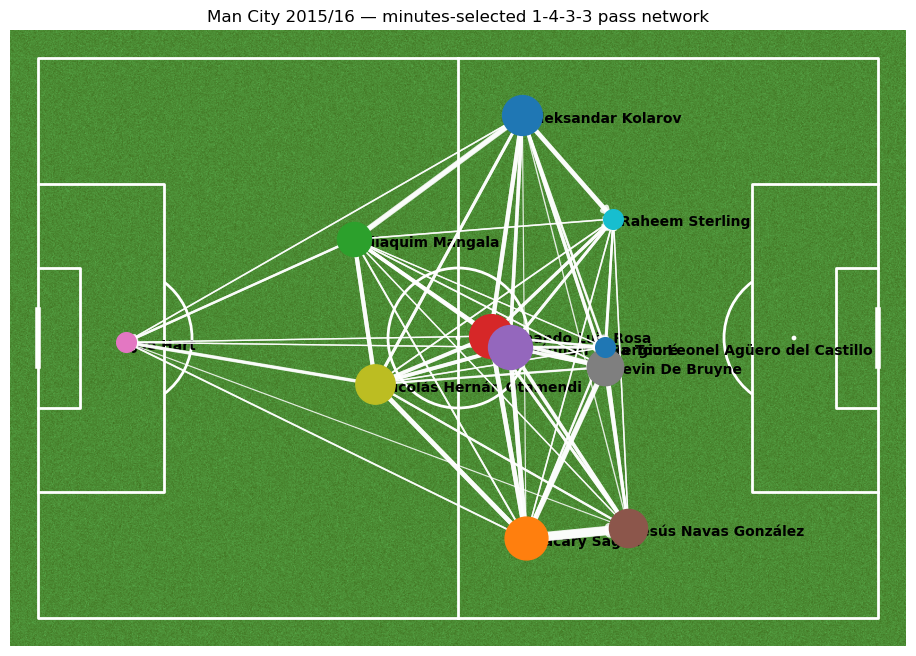

In [32]:
# Robust player-level minutes-selected XI plotting (fixed for numpy ptp)
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch

# Basic sanity checks
if 'avgpos_xi_minutes' not in globals():
    raise RuntimeError("avgpos_xi_minutes not found. Run the minutes-XI averaging cell first.")
if 'edge_stats_xi_pruned' not in globals():
    raise RuntimeError("edge_stats_xi_pruned not found. Run the edge aggregation/prune cell first.")

# Build graph G from avg positions and edge table
G = nx.DiGraph()
for p in avgpos_xi_minutes.index:
    G.add_node(p, x=float(avgpos_xi_minutes.loc[p, 'x']), y=float(avgpos_xi_minutes.loc[p, 'y']))

for _, r in edge_stats_xi_pruned.iterrows():
    u, v, w = r['player'], r['recipient_name'], int(r['attempts'])
    if u in G.nodes and v in G.nodes:
        G.add_edge(u, v, weight=w)

nodes = list(G.nodes())
if len(nodes) == 0:
    raise RuntimeError("Graph G is empty — ensure avgpos_xi_minutes and edge_stats_xi_pruned exist and overlap.")

# Build touch map (prefer touch_df_xi if available)
if 'touch_df_xi' in globals():
    touch_map = dict(zip(touch_df_xi['player'], touch_df_xi['touches']))
else:
    # fallback: compute from filtered
    if 'filtered' in globals():
        touch_map = pd.concat([filtered['player'], filtered['recipient_name']]).value_counts().to_dict()
    else:
        touch_map = {n: 10 for n in nodes}

# compute node sizes robustly
touch_values = np.array([touch_map.get(n, 10) for n in nodes], dtype=float)
ptp = float(np.ptp(touch_values))  # range (max-min)
if ptp == 0:
    node_sizes = np.full(len(nodes), 300.0)
else:
    node_sizes = 200.0 + (touch_values - touch_values.min()) / ptp * 800.0

# plotting: create fig/ax then draw pitch on that axis (compatible across mplsoccer versions)
fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
# draw onto our axis
try:
    pitch.draw(ax=ax)
except TypeError:
    try:
        # some mplsoccer versions return fig, ax
        _fig, _ax = pitch.draw(figsize=(12,8))
        fig, ax = _fig, _ax
    except Exception:
        # last resort: fall back to default draw
        fig, ax = pitch.draw()

# draw nodes and labels
for i, n in enumerate(nodes):
    x = G.nodes[n]['x']; y = G.nodes[n]['y']
    ax.scatter(x, y, s=node_sizes[i], zorder=4)
    ax.text(x + 1, y + 1, n, fontsize=10, weight='bold')

# draw edges scaled by weight
maxw = max((d['weight'] for _,_,d in G.edges(data=True)), default=1)
for u, v, d in G.edges(data=True):
    x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
    x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
    lw = 0.8 + 6.0 * (d['weight'] / maxw)
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='-|>', linewidth=lw, alpha=0.85, color='white'))

plt.title("Man City 2015_16 — minutes-selected 1-4-3-3 pass network")
plt.show()

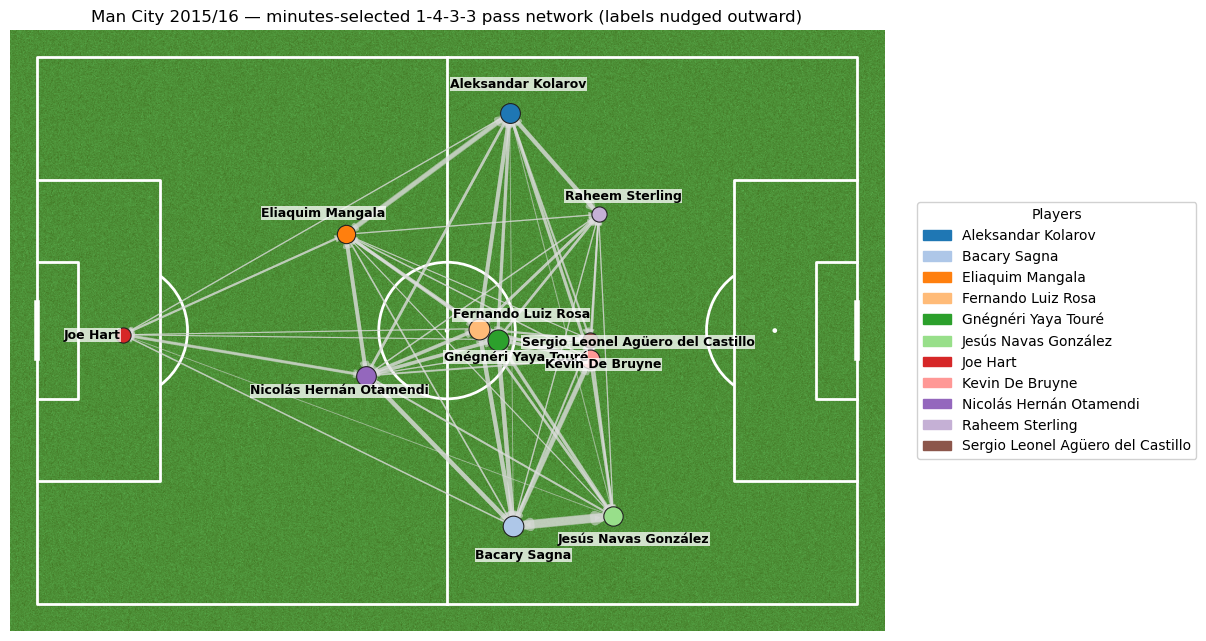

In [33]:
# Improved plotting: smaller nodes, edges behind text, label nudging outward and legend
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib

# Parameters you can tweak
NODE_BASE = 120.0      # base node marker size (increase to make nodes larger)
NODE_SCALE = 0.9       # additional scale factor for computed sizes
LABEL_OFFSET = 4.5     # how far to push label outward from player (in pitch units)
EDGE_ALPHA = 0.55      # transparency of edges
EDGE_COLOR = '#dddddd' # base edge color
NODE_EDGE_COLOR = '#222222'  # outline for nodes
TEXT_BBOX = dict(facecolor='white', alpha=0.75, linewidth=0, pad=0.3)  # label box

# sanity checks
if 'avgpos_xi_minutes' not in globals() or 'edge_stats_xi_pruned' not in globals():
    raise RuntimeError("Please run the average-position & edge-prune cells before plotting.")

# Build graph G if not already built
if 'G' not in globals():
    G = nx.DiGraph()
    for p in avgpos_xi_minutes.index:
        G.add_node(p, x=float(avgpos_xi_minutes.loc[p,'x']), y=float(avgpos_xi_minutes.loc[p,'y']))
    for _, r in edge_stats_xi_pruned.iterrows():
        u,v,w = r['player'], r['recipient_name'], int(r['attempts'])
        if u in G.nodes and v in G.nodes:
            G.add_edge(u,v, weight=w)

nodes = list(G.nodes())
if not nodes:
    raise RuntimeError("Graph is empty. Recompute avg positions and edges.")

# color map: distinct color per player
cmap = plt.get_cmap('tab20')
colors = {n: cmap(i % cmap.N) for i, n in enumerate(nodes)}

# node size mapping using touch counts (fallback to touch_df_xi)
if 'touch_df_xi' in globals():
    touch_map = dict(zip(touch_df_xi['player'], touch_df_xi['touches']))
else:
    touch_map = {n:10 for n in nodes}

touch_values = np.array([touch_map.get(n,10) for n in nodes], dtype=float)
ptp = float(np.ptp(touch_values)) if touch_values.size>0 else 1.0
if ptp == 0:
    size_norm = np.ones_like(touch_values)
else:
    size_norm = (touch_values - touch_values.min()) / ptp
node_sizes = NODE_BASE + NODE_BASE * size_norm * NODE_SCALE

# determine pitch centre to compute outward label direction
PITCH_CENTER = (60.0, 40.0)

# Create figure/axis and draw pitch
fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
try:
    pitch.draw(ax=ax)
except TypeError:
    try:
        _fig, _ax = pitch.draw(figsize=(12,8))
        fig, ax = _fig, _ax
    except Exception:
        fig, ax = pitch.draw()

# draw edges first (behind nodes)
maxw = max((d['weight'] for _,_,d in G.edges(data=True)), default=1)
for u, v, d in G.edges(data=True):
    x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
    x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
    lw = 0.6 + 6.0 * (d['weight'] / maxw)
    # draw a faint colored line behind everything
    ax.annotate("", xy=(x2,y2), xytext=(x1,y1),
                arrowprops=dict(arrowstyle='-|>', linewidth=lw, alpha=EDGE_ALPHA, color=EDGE_COLOR),
                zorder=1)

# draw nodes (on top of edges)
for i, n in enumerate(nodes):
    x = G.nodes[n]['x']; y = G.nodes[n]['y']
    ax.scatter(x, y, s=node_sizes[i], zorder=3, edgecolor=NODE_EDGE_COLOR, linewidth=0.8, facecolor=colors[n])

# label placement: push labels outward from pitch centre to reduce overlap in middle
labels = {}
for n in nodes:
    x = G.nodes[n]['x']; y = G.nodes[n]['y']
    # vector from centre to node
    vx = x - PITCH_CENTER[0]; vy = y - PITCH_CENTER[1]
    norm = np.hypot(vx, vy)
    if norm == 0:
        # if exactly center, place label above
        dx, dy = 0.0, LABEL_OFFSET
    else:
        dx, dy = (vx / norm) * LABEL_OFFSET, (vy / norm) * LABEL_OFFSET
    lx, ly = x + dx, y + dy
    labels[n] = (lx, ly)

# Secondary mild collision avoidance: if two labels are extremely close, nudge them slightly perpendicular
label_items = list(labels.items())
for i in range(len(label_items)):
    n1, (lx1, ly1) = label_items[i]
    for j in range(i+1, len(label_items)):
        n2, (lx2, ly2) = label_items[j]
        dist = np.hypot(lx1 - lx2, ly1 - ly2)
        if dist < 4.0:  # threshold: if too close, push them sideways
            # compute perpendicular vector to line connecting points
            dx = lx2 - lx1; dy = ly2 - ly1
            perp_x, perp_y = -dy, dx
            pnorm = np.hypot(perp_x, perp_y)
            if pnorm == 0:
                perp_x, perp_y = 1.0, 0.0
                pnorm = 1.0
            shift = 2.5  # small nudge
            # nudge first one negative, second positive
            labels[n1] = (labels[n1][0] - perp_x/pnorm*shift, labels[n1][1] - perp_y/pnorm*shift)
            labels[n2] = (labels[n2][0] + perp_x/pnorm*shift, labels[n2][1] + perp_y/pnorm*shift)

# draw labels on top with white bbox for contrast
for n, (lx, ly) in labels.items():
    ax.text(lx, ly, n, fontsize=9, weight='bold', zorder=5,
            bbox=TEXT_BBOX, ha='center', va='center')

# build legend on the right: color swatches for each player, with a compact box
legend_handles = [mpatches.Patch(color=colors[n], label=n) for n in nodes]
# place legend outside pitch
legend = ax.legend(handles=legend_handles, title="Players", bbox_to_anchor=(1.03, 0.5), loc='center left', frameon=True)
legend.get_frame().set_alpha(0.9)

plt.title("Man City 2015_16 — minutes-selected 1-4-3-3 pass network (labels nudged outward)")
plt.tight_layout()
plt.show()

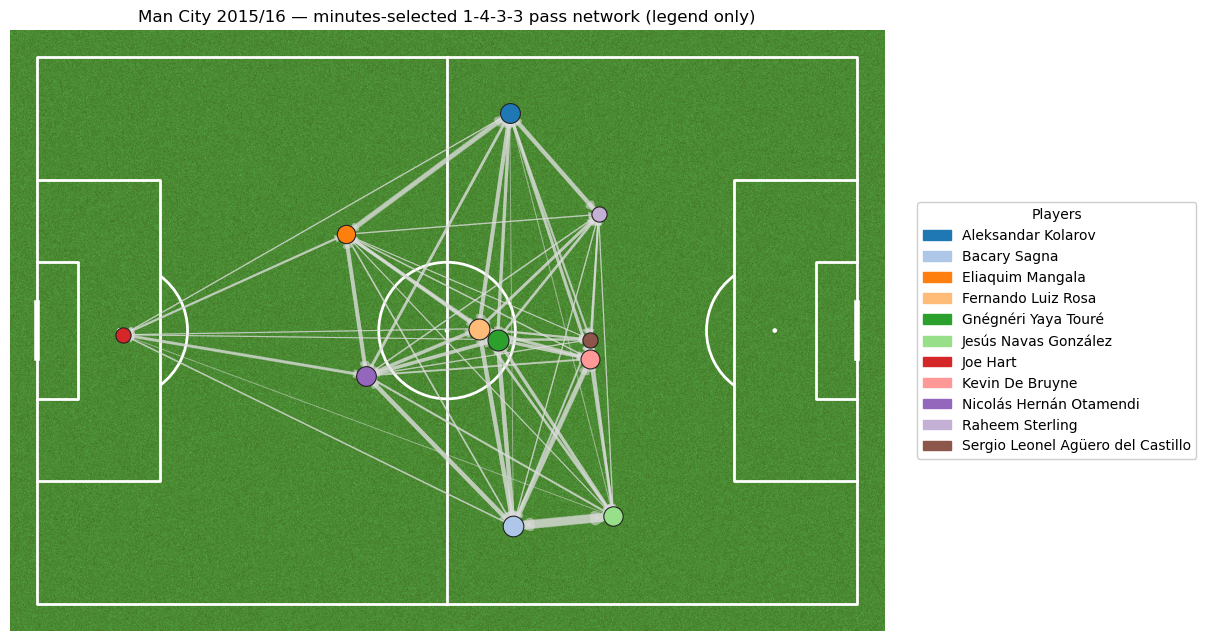

In [34]:
# Plot pass network with NO on-pitch labels — legend only
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch
import networkx as nx
import matplotlib.patches as mpatches

# params
NODE_BASE = 120.0
NODE_SCALE = 0.9
LABEL_OFFSET = 4.5
EDGE_ALPHA = 0.55
EDGE_COLOR = '#dddddd'
NODE_EDGE_COLOR = '#222222'

# sanity checks
if 'avgpos_xi_minutes' not in globals() or 'edge_stats_xi_pruned' not in globals():
    raise RuntimeError("Please run the avgpos & edge aggregation/prune cells before plotting this.")

# (re)build graph if needed
if 'G' not in globals():
    G = nx.DiGraph()
    for p in avgpos_xi_minutes.index:
        G.add_node(p, x=float(avgpos_xi_minutes.loc[p,'x']), y=float(avgpos_xi_minutes.loc[p,'y']))
    for _, r in edge_stats_xi_pruned.iterrows():
        u,v,w = r['player'], r['recipient_name'], int(r['attempts'])
        if u in G.nodes and v in G.nodes:
            G.add_edge(u,v, weight=w)

nodes = list(G.nodes())
if not nodes:
    raise RuntimeError("Graph is empty. Recompute avg positions and edges.")

# color map per player
cmap = plt.get_cmap('tab20')
colors = {n: cmap(i % cmap.N) for i, n in enumerate(nodes)}

# node size mapping
if 'touch_df_xi' in globals():
    touch_map = dict(zip(touch_df_xi['player'], touch_df_xi['touches']))
else:
    touch_map = {n:10 for n in nodes}

touch_values = np.array([touch_map.get(n,10) for n in nodes], dtype=float)
ptp = float(np.ptp(touch_values)) if touch_values.size>0 else 1.0
size_norm = np.ones_like(touch_values) if ptp == 0 else (touch_values - touch_values.min()) / ptp
node_sizes = NODE_BASE + NODE_BASE * size_norm * NODE_SCALE

# draw
fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
try:
    pitch.draw(ax=ax)
except TypeError:
    try:
        _fig, _ax = pitch.draw(figsize=(12,8)); fig=_fig; ax=_ax
    except Exception:
        fig, ax = pitch.draw()

# edges behind nodes
maxw = max((d['weight'] for _,_,d in G.edges(data=True)), default=1)
for u, v, d in G.edges(data=True):
    x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
    x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
    lw = 0.6 + 6.0 * (d['weight'] / maxw)
    ax.annotate("", xy=(x2,y2), xytext=(x1,y1),
                arrowprops=dict(arrowstyle='-|>', linewidth=lw, alpha=EDGE_ALPHA, color=EDGE_COLOR),
                zorder=1)

# nodes on top
for i, n in enumerate(nodes):
    x = G.nodes[n]['x']; y = G.nodes[n]['y']
    ax.scatter(x, y, s=node_sizes[i], zorder=3, edgecolor=NODE_EDGE_COLOR, linewidth=0.8, facecolor=colors[n])

# create legend only (no on-pitch labels)
legend_handles = [mpatches.Patch(color=colors[n], label=n) for n in nodes]
legend = ax.legend(handles=legend_handles, title="Players", bbox_to_anchor=(1.03, 0.5), loc='center left', frameon=True)
legend.get_frame().set_alpha(0.95)

plt.title("Man City 2015_16 — minutes-selected 1-4-3-3 pass network (legend only)")
plt.tight_layout()
plt.show()

In [35]:
import os
os.makedirs("outputs", exist_ok=True)
print("outputs/ created at", os.path.abspath("outputs"))

outputs/ created at /Users/jcwiddaglizze/projects/football-passing/notebooks/outputs


In [36]:
# using plt
plt.savefig("outputs/mancity_2015_16_pass_network.png", dpi=300, bbox_inches="tight")
# and optionally PDF
plt.savefig("outputs/mancity_2015_16_pass_network.pdf", bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

In [37]:
fig.savefig("outputs/mancity_2015_16_pass_network.png", dpi=300, bbox_inches="tight")

In [38]:
import os
print("Notebook working dir:", os.getcwd())

Notebook working dir: /Users/jcwiddaglizze/projects/football-passing/notebooks


In [39]:
import os
os.makedirs("outputs", exist_ok=True)   # safe: creates folder where the notebook kernel will write
fig.savefig("outputs/mancity_2015_16_pass_network.png", dpi=300, bbox_inches="tight")
# optionally save pdf
fig.savefig("outputs/mancity_2015_16_pass_network.pdf", bbox_inches="tight")
plt.show()

In [40]:
import os
os.makedirs("outputs", exist_ok=True)
plt.savefig("outputs/mancity_2015_16_pass_network.png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

Saved PNG: /Users/jcwiddaglizze/projects/football-passing/notebooks/outputs/mancity_2015_16_pass_network.png
Saved PDF: /Users/jcwiddaglizze/projects/football-passing/notebooks/outputs/mancity_2015_16_pass_network.pdf


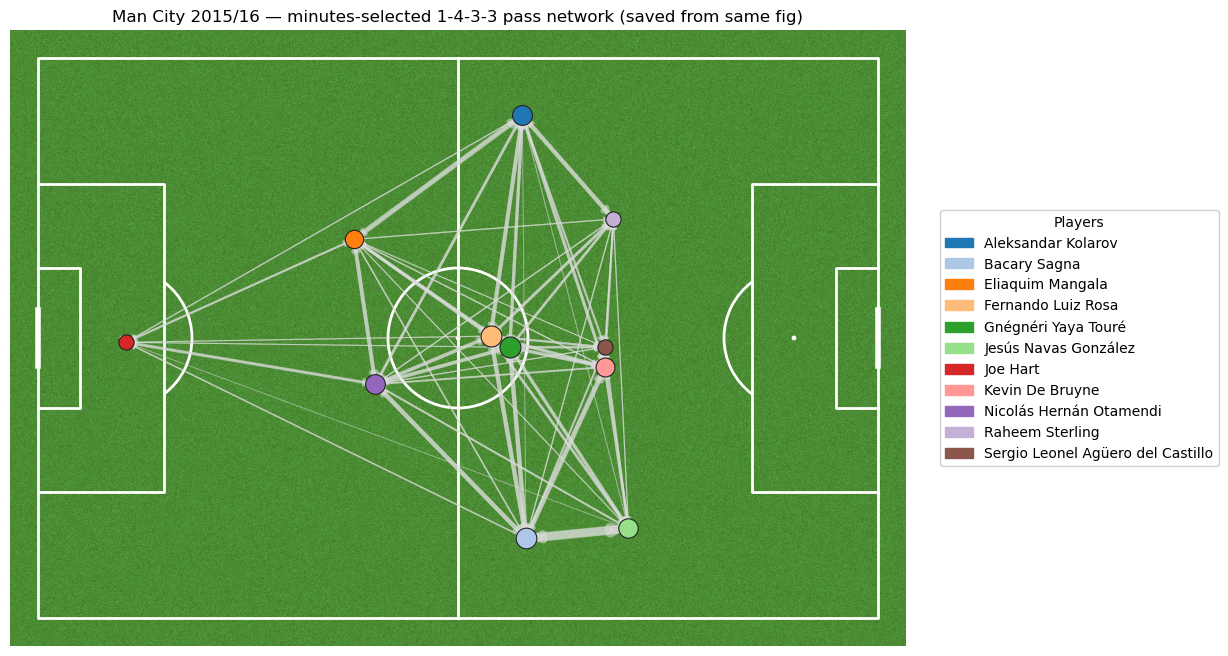


outputs/ contents:
  mancity_2015_16_pass_network.pdf - 421827 bytes
  mancity_2015_16_pass_network.png - 6869291 bytes


In [41]:
# One-cell: redraw the minutes-selected XI network and save using the same fig object
import os, math, numpy as np, matplotlib.pyplot as plt
from mplsoccer import Pitch
import networkx as nx
import matplotlib.patches as mpatches

# --- safety checks: required data from earlier cells ---
if 'avgpos_xi_minutes' not in globals() or 'edge_stats_xi_pruned' not in globals():
    raise RuntimeError("Need avgpos_xi_minutes and edge_stats_xi_pruned in the notebook. Run the aggregation/prune cells first.")

# Rebuild graph G from the averaged positions + pruned edges (guarantees consistency)
G = nx.DiGraph()
for p in avgpos_xi_minutes.index:
    G.add_node(p, x=float(avgpos_xi_minutes.loc[p,'x']), y=float(avgpos_xi_minutes.loc[p,'y']))

for _, r in edge_stats_xi_pruned.iterrows():
    u,v,w = r['player'], r['recipient_name'], int(r['attempts'])
    if u in G.nodes and v in G.nodes:
        G.add_edge(u, v, weight=w)

nodes = list(G.nodes())
if not nodes:
    raise RuntimeError("Graph G is empty. Recompute avg positions and edges.")

# node colors and sizes (as before)
cmap = plt.get_cmap('tab20')
colors = {n: cmap(i % cmap.N) for i, n in enumerate(nodes)}
if 'touch_df_xi' in globals():
    touch_map = dict(zip(touch_df_xi['player'], touch_df_xi['touches']))
else:
    touch_map = {n: 10 for n in nodes}
touch_values = np.array([touch_map.get(n,10) for n in nodes], dtype=float)
ptp = float(np.ptp(touch_values)) if touch_values.size>0 else 1.0
size_norm = np.ones_like(touch_values) if ptp == 0 else (touch_values - touch_values.min()) / ptp
NODE_BASE = 120.0; NODE_SCALE = 0.9
node_sizes = NODE_BASE + NODE_BASE * size_norm * NODE_SCALE

# --- Create figure & axis and draw pitch onto that axis ---
fig, ax = plt.subplots(figsize=(12,8))
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
# draw onto our axis in a version-compatible way
try:
    pitch.draw(ax=ax)
except TypeError:
    try:
        _fig, _ax = pitch.draw(figsize=(12,8))
        fig, ax = _fig, _ax
    except Exception:
        fig, ax = pitch.draw()

# draw edges behind nodes
maxw = max((d['weight'] for _,_,d in G.edges(data=True)), default=1)
for u, v, d in G.edges(data=True):
    x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
    x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
    lw = 0.6 + 6.0 * (d['weight'] / maxw)
    ax.annotate("", xy=(x2,y2), xytext=(x1,y1),
                arrowprops=dict(arrowstyle='-|>', linewidth=lw, alpha=0.55, color='#dddddd'),
                zorder=1)

# draw nodes on top
NODE_EDGE_COLOR = '#222222'
for i, n in enumerate(nodes):
    x = G.nodes[n]['x']; y = G.nodes[n]['y']
    ax.scatter(x, y, s=node_sizes[i], zorder=3, edgecolor=NODE_EDGE_COLOR, linewidth=0.8, facecolor=colors[n])

# legend only (no on-pitch labels)
legend_handles = [mpatches.Patch(color=colors[n], label=n) for n in nodes]
legend = ax.legend(handles=legend_handles, title="Players", bbox_to_anchor=(1.03, 0.5), loc='center left', frameon=True)
legend.get_frame().set_alpha(0.95)

plt.title("Man City 2015_16 — minutes-selected 1-4-3-3 pass network (saved from same fig)")

# --- Ensure outputs folder exists relative to notebook working dir, save using fig ---
outdir = os.path.abspath("outputs")
os.makedirs(outdir, exist_ok=True)
png_path = os.path.join(outdir, "mancity_2015_16_pass_network.png")
pdf_path = os.path.join(outdir, "mancity_2015_16_pass_network.pdf")

fig.savefig(png_path, dpi=300, bbox_inches="tight")
fig.savefig(pdf_path, bbox_inches="tight")
print("Saved PNG:", png_path)
print("Saved PDF:", pdf_path)

# show the figure inline too
plt.show()

# list outputs dir to confirm file sizes
print("\noutputs/ contents:")
for e in sorted(os.listdir(outdir)):
    p = os.path.join(outdir, e)
    print(" ", e, "-", os.path.getsize(p), "bytes")